In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import ROOT
# import root_numpy
import sys
import os

sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')

from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from PyUtils.fileUtils import makeDirs, copyFile
# from PyUtils.tdrStyle import setTDRStyle
from d0_Utils.d0_fns import (combine_cut_list, calc_num_bins, make_str_title_friendly, 
                             calc_ymin_for_legend, print_header_message)
from d0_Utils.d0_dicts import (charge_dict, color_dict)
# from d0_Utils.d0_Analyzer_with_fancy_functions import HistInfo

pd.options.display.max_columns = 28
# pd.options.display.max_columns = None

In [ ]:
# Default plotting parameters.
#     plt.rc('font', size=text_size_medium)          # controls default text sizes
# plt.rc('axes', titlesize=text_size_title)     # fontsize of the axes title
# plt.rc('axes', labelsize=text_size_ax_labels)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=text_size_tick_labels)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=text_size_tick_labels)    # fontsize of the tick labels
# plt.rc('legend', fontsize=text_size_legend)    # legend fontsize
#     plt.rc('figure', titlesize=text_size_medium)  # fontsize of the figure title

In [2]:
class HistInfo:
    
    def __init__(self):
        pass
#                  year,
#                  charge,
#                  bspv,
#                  binning_style,  # 'pT' or 'eta',
#                  n_bins,
#                  x_axis_bounds_list, # 2-element list
#                  d0_bin_bounds_list,
#                  eta_bin_bounds_list,
#                  pT_cuts_internal_list,
#                  massZ_cut,
#                  test_in_tier2,
#                  make_big_pdf):

#         self.year      = year
#         self.bspv      = bspv
#         self.bin_style = binning_style
#         self.x_bounds = x_axis_bounds_list
#         self.d0_bin_bounds = d0_bin_bounds_list  # A 2-element list.
#         self.eta_bin_bounds = eta_bin_bounds_list
#         self.pT_cuts    = pT_cuts_internal_list  # Was pT_low_str and pT_high_str
#         self.massZ_cut = massZ_cut
#         self.n_bins    = n_bins
#         self.test_in_tier2 = test_in_tier2
#         self.make_big_pdf = make_big_pdf
        
#         self.ID        = charge_dict[charge]
        
# #         self.draw_hist()
    
#     def draw_hist(self):
        
#         year      = self.year
#         tree      = self.tree
#         charge    = self.charge
#         bspv      = self.bspv
#         bin_style = self.bin_style
#         pT_cuts    = self.pT_cuts  # Was pT_low_str and pT_high_str
#         massZ_cut = self.massZ_cut
#         n_bins    = self.n_bins
#         ID        = self.ID
        
#         x_min = self.x_bounds[0]
#         x_max = self.x_bounds[1]
#         this_d0_str = str(self.d0_bin_bounds[0])
#         next_d0_str = str(self.d0_bin_bounds[1])
#         this_eta_str = str(self.eta_bin_bounds[0])
#         next_eta_str = str(self.eta_bin_bounds[1])
#         pT_low_str = str(self.pT_cuts[0])
#         pT_high_str = str(self.pT_cuts[1])
               
        
#         c = ROOT.TCanvas()
#         c.cd()

#         if bin_style in 'eta':
#             cuts_per_event  = "(Id1 == %s && %s < d0%s1 && d0%s1 < %s && %s < eta1 && eta1 < %s && %s < pT1 && pT1 < %s) || " % (ID, this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str, pT_low_str, pT_high_str)
#             cuts_per_event += "(Id2 == %s && %s < d0%s2 && d0%s2 < %s && %s < eta2 && eta2 < %s && %s < pT2 && pT2 < %s)"     % (ID, this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str, pT_low_str, pT_high_str)
#             hist_name = "deltapT_mu%s_%s__%s_pT_%s__%s_eta_%s__%s_d0_%s" % (charge, bspv, pT_low_str, pT_high_str, this_eta_str, next_eta_str, this_d0_str, next_d0_str)
#         # WARNING: 'this_pT_str' is NOT the same as 'pT_low_str'
#         # 'this_pT_str' is for binning over pT, whereas 'pT_low_str' is for implicit pT cuts during eta binning.

#         #----- NEEDS DEBUGGING AND TESTING -----#
#         elif bin_style in 'pT':
#             cuts_per_event  = "(Id1 == %s && %s < d0%s1 && d0%s1 < %s && %s < pT1 && pT1 < %s) || " % (ID, this_d0_str, bspv, bspv, next_d0_str, this_pT_str, next_pT_str)
#             cuts_per_event += "(Id2 == %s && %s < d0%s2 && d0%s2 < %s && %s < pT2 && pT2 < %s)"     % (ID, this_d0_str, bspv, bspv, next_d0_str, this_pT_str, next_pT_str)
#             hist_name = "deltapT_mu%s_%s__%s_pT_%s__%s_d0_%s" % (charge, bspv, this_pT_str, next_pT_str, this_d0_str, next_d0_str) 
# #         elif bin_style in 'eta_with_pT_cut'
#         #---------------------------------------#

#         if len(massZ_cut) != 0:
#             cuts_per_event = "("+cuts_per_event+") && %s" % (massZ_cut)

#         hist_name = make_str_title_friendly(hist_name)  
#         hist_name = hist_name.replace('+','pos') # Must do this because fn() above doesn't work for some reason?
#         hist_name = hist_name.replace('-','neg')

#         h = ROOT.TH1F(hist_name, cuts_per_event, n_bins, x_min, x_max)
        
#         # Fill up the histo with either lep1's deltapT info, if it has the ID of interest.
#         # Otherwise use the other lep's deltapT info.
#         tricky_root_expr  = "10000*(pT1-genLep_pt1)/genLep_pt1/genLep_pt1*(Id1==%s) + " % ID
#         tricky_root_expr += "10000*(pT2-genLep_pt2)/genLep_pt2/genLep_pt2*(Id2==%s)" % ID
#         #--- Confirmed that this works by using a Google Spreadsheet! ---#
        
#         # Extract mean, RMS, and store for later.
#         #--- FIXME! Implement a fit with CBxBW + exp
#         #--- FIXME! Implement a fit with Voigtian
        
            
#         if (verbose):
# #             print "deltapT_mean_list:", deltapT_mean_list
# #             print "deltapT_mean_err_list:", deltapT_mean_err_list
#             if bin_style in 'eta':
#                 print("Completed %s<pT<%s, %s<eta<%s, %s<d0%s<%s \n" % (pT_low_str, pT_high_str, this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str))
#                 print("Here's the important stored info:")
#                 print("self.c", self.c)
#                 print("self.h", self.h)
#                 print("self.tree", self.tree)
#                 print("self.hist_name", self.hist_name)
#                 print("self.cuts_per_event", self.cuts_per_event)
#                 print("self.h_mean", self.h_mean)
#                 print("self.h_mean_err", self.h_mean_err)
#                 print("self.h_stdev", self.h_stdev)
#                 print("self.h_stdev_err", self.h_stdev_err)
#             if bin_style in 'pT':
#                 print("Completed %s<pT<%s, %s<d0%s<%s \n" % (this_pT_str, next_pT_str, this_d0_str, bspv, next_d0_str))
                
#         if (make_plots_deltapT_vs_d0):
#             return mean, mean_err

In [20]:
def calc_x_err_bins(x_val_center_list):
    """
    Returns lists of the x-errors, which may be symmetrical or asymmetrical. 
    """
    high_err_list = []
    for x_center in range(len(x_val_center_list)-1):
        high_err = float( x_val_center_list[x_center+1] - x_val_center_list[x_center] ) / 2
        high_err_list.append(high_err)
        
    low_err_list = [high_err_list[0]] + high_err_list
    high_err_list = high_err_list + [high_err_list[-1]]
    
    return low_err_list, high_err_list

def make_deltapT_pdf(df, year, sample, 
                     bspv, 
                     d0_range_ls, 
                     deltapT_range_ls, 
                     pT_cut_ls, 
                     eta_cut_ls, 
                     outfile_path,
                     wrt="pT_gen",
                     shoulder_cut=(False,-999),
                     save_plots=False, overwrite=False):

    """
    Takes in a DataFrame (df) corresponding to an entire '.root' file and generates a '.pdf' with 
    many deltapT/pT^2 histograms, one histo for each d0 bin. 
    Each histo has the same cuts based on:
        bspv : 'BS' or 'PV'
        deltapT_range_ls : [deltapT_min, deltapT_max, deltapT_bin_width]
        pT_cut_ls : [pT_min, pT_max]
        eta_cut_ls : [eta_min, eta_max]
        
    The df you pass in has a: 
        year : 
        sample : 'MC' or 'Data'
        
    #--- Details ---#
    Go through each event and see if mu1 passes all selection criteria.
    Demand that d0BS1*charge(mu1) fall within specified d0' bin
    Make a DataFrame with all events that pass these selections.
    Do the same thing for mu2 and make another DataFrame.
    
    Returns
    -------
    A list of HistInfo objects. 
    Each HistInfo object contains all the important information from each deltapT histogram. 
    
    If save_plots=True, then will make a '.pdf' showing each deltapT histogram. 
    """

    textsize_legend = 8
    textsize_axislabels = 10
    textsize_ticklabels = 8
    textsize_title = 10
    
    d0_min = d0_range_ls[0]
    d0_max = d0_range_ls[1]
    d0_bin_width = d0_range_ls[2]

    deltapT_min = deltapT_range_ls[0]
    deltapT_max = deltapT_range_ls[1]    
    deltapT_bin_width = deltapT_range_ls[2]    
    
    pT_min = pT_cut_ls[0]
    pT_max = pT_cut_ls[1]
    
    eta_min = eta_cut_ls[0]
    eta_max = eta_cut_ls[1]
    
    massZ_min = 50
    
    d0_bin_arr = np.arange(d0_min, d0_max+0.5*d0_bin_width, d0_bin_width)  # Includes all bin edges: very first to very last.
    d0_bin_arr_shifted = d0_bin_arr[0:-1] + 0.5*d0_bin_width  # Make sure points are plotted in middle of bin window.
#     d0_n_bins = calc_num_bins(d0_min, d0_max, d0_bin_width)
    deltapT_arr = np.arange(deltapT_min, deltapT_max+0.5*deltapT_bin_width, deltapT_bin_width)
    
    pdf_name  = f"{year}_{sample}_{bspv}__"
    title_str_pT_min = f"0{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
    # Example of Python magic: auto-concatenation of strings.
    pdf_name += (f"{title_str_pT_min}_pT_{pT_max}"
                 f"__{eta_min}_eta_{eta_max}"
                 f"__{d0_min:.3f}_to_{d0_max:.3f}_increm_{d0_bin_width:.3f}"
                 f"__wrt_{wrt}")
    if (shoulder_cut[0]):
        pdf_name += f"__abs_1E4dptoverpt2_lt_{shoulder_cut[1]}"
    pdf_name = make_str_title_friendly(pdf_name) + ".pdf"
    
    outfile = os.path.join(outfile_path, pdf_name)
    if not os.path.exists(outfile_path):
        os.makedirs(outfile_path)
    if os.path.exists(outfile) and not (overwrite):
        raise RuntimeError(f"File already exists:\n{outfile}\n\nYou can set overwrite=True. Stopping now.")
        
    status = f"Running over: {year} {sample} {bspv}, pT_range={pT_cut_ls}, eta_range={eta_cut_ls}, wrt {wrt}"
    if (shoulder_cut[0]):
        status += f", using shoulder_cut={shoulder_cut[1]} GeV"
    print(status)

    with PdfPages(outfile) as pdf:
        charge1_ser = df['Id1'].replace(13,-1).replace(-13,1)
        charge2_ser = df['Id2'].replace(13,-1).replace(-13,1)

        d0BS1xcharge_ser = charge1_ser * df['d0BS1']
        d0BS2xcharge_ser = charge2_ser * df['d0BS2']
        d0PV1xcharge_ser = charge1_ser * df['d0PV1']
        d0PV2xcharge_ser = charge2_ser * df['d0PV2']  
        
        graph_info_ls = []
        
        for k in range(len(d0_bin_arr)-1):
            this_d0_bin = d0_bin_arr[k]
            next_d0_bin = d0_bin_arr[k+1]
            if bspv in 'BS':
                mask_d0BS1xcharge = (this_d0_bin < d0BS1xcharge_ser) & (d0BS1xcharge_ser < next_d0_bin)
                mask_d0BS2xcharge = (this_d0_bin < d0BS2xcharge_ser) & (d0BS2xcharge_ser < next_d0_bin)
            elif bspv in 'PV':
                mask_d0PV1xcharge = (this_d0_bin < d0PV1xcharge_ser) & (d0PV1xcharge_ser < next_d0_bin)
                mask_d0PV2xcharge = (this_d0_bin < d0PV2xcharge_ser) & (d0PV2xcharge_ser < next_d0_bin)

            # Masks (the cuts).
            mask_massZ = massZ_min < df['massZ']
            
            mask_pT1 = (pT_min < df['pT1']) & (df['pT1'] < pT_max)
            mask_pT2 = (pT_min < df['pT2']) & (df['pT2'] < pT_max)

            mask_eta1 = (eta_min < df['eta1']) & (df['eta1'] < eta_max)
            mask_eta2 = (eta_min < df['eta2']) & (df['eta2'] < eta_max)
            
            if (shoulder_cut[0]):
                mask_shoulder_cut1 = abs((df['pT1'] - df['genLep_pt1']) / df['genLep_pt1']**2 * 1E4) < shoulder_cut[1]
                mask_shoulder_cut2 = abs((df['pT2'] - df['genLep_pt2']) / df['genLep_pt2']**2 * 1E4) < shoulder_cut[1]
            else:
                mask_shoulder_cut1 = mask_massZ  # Don't apply a cut on the shoulder. So just copy another mask.
                mask_shoulder_cut2 = mask_massZ

            # Apply all masks.
            # df[mask_d0_lep1 & mask_eta1]['massZ'].hist(bins=100)
            if bspv in 'BS':
                original_masked_df1 = df[(mask_d0BS1xcharge & mask_pT1 & mask_eta1 & mask_massZ & mask_shoulder_cut1)]
                original_masked_df2 = df[(mask_d0BS2xcharge & mask_pT2 & mask_eta2 & mask_massZ & mask_shoulder_cut2)]
            elif bspv in 'PV':
                original_masked_df1 = df[(mask_d0PV1xcharge & mask_pT1 & mask_eta1 & mask_massZ & mask_shoulder_cut1)]
                original_masked_df2 = df[(mask_d0PV2xcharge & mask_pT2 & mask_eta2 & mask_massZ & mask_shoulder_cut2)]

            if wrt in "pT_gen":
                deltapT1_over_pTsqrd_ser = (original_masked_df1.pT1 - original_masked_df1.genLep_pt1) / original_masked_df1.genLep_pt1**2 * 1E4
                deltapT2_over_pTsqrd_ser = (original_masked_df2.pT2 - original_masked_df2.genLep_pt2) / original_masked_df2.genLep_pt2**2 * 1E4
            
            elif wrt in "pT_reco":
                deltapT1_over_pTsqrd_ser = (original_masked_df1.pT1 - original_masked_df1.genLep_pt1) / original_masked_df1.pT1**2 * 1E4
                deltapT2_over_pTsqrd_ser = (original_masked_df2.pT2 - original_masked_df2.genLep_pt2) / original_masked_df2.pT2**2 * 1E4   

            # Muon1 has been checked for each event and one series was made.
            # Then muon2 was checked and a series was made. Combine both series.
            combined_deltapT_ser = deltapT1_over_pTsqrd_ser.append( deltapT2_over_pTsqrd_ser )
            
            # Example of Python magic. Auto-concatenation of strings.
            cuts = (f"{this_d0_bin:.3f}" + r"$<d_{0}^{%s}*\mathrm{charge}(\mu)<$"%bspv + f"{next_d0_bin:.3f}, "
                    "\n"
                    f"{pT_min}<" + r"$p_{T}^{RECO}$" + f"<{pT_max} GeV, "
                    f"{eta_min}<" + r"$\left| \eta \right|$<" + f"{eta_max}, "
                    f"{massZ_min}<" + r"$m_{\mu\mu}$")
            if (shoulder_cut[0]):
                cuts += r", $\left| \Delta p_{T}/(p_{T})^2 \right|<$" + f"{shoulder_cut[1]}"
                
            # Statistics.
            n_entries = len(combined_deltapT_ser)
            mean = combined_deltapT_ser.mean()
            mean_err = abs(mean) / np.sqrt(n_entries)  # Standard error of the mean.
            stdev = combined_deltapT_ser.std()
            stdev_err = stdev / np.sqrt(2*n_entries)

            # Store info of this plot in a HistInfo object. 
            this_hist = HistInfo()            
            this_hist.year = year
            this_hist.sample = sample
            this_hist.bspv = bspv
            this_hist.d0_bin_window = [this_d0_bin, next_d0_bin]
            this_hist.x_axis_bounds_list = deltapT_range_ls[0:2] # 2-element list
            this_hist.eta_range = eta_cut_ls
            this_hist.pT_range = pT_cut_ls
            this_hist.massZ_cut = massZ_min
            this_hist.shoulder_cut = shoulder_cut[1] if shoulder_cut[0] else None
            this_hist.n_entries = n_entries
            this_hist.hist_mean = mean
            this_hist.hist_mean_err = mean_err
            this_hist.hist_stdev = stdev  # Spread of the data.
            this_hist.hist_stdev_err = stdev_err
            
            graph_info_ls.append(this_hist)
            
            # Plotting
            fig, ax = plt.subplots()
            ax.tick_params(axis='both', which='major', direction='in', length=9,   top=True, right=True)
            ax.tick_params(axis='both', which='minor', direction='in', length=4.5, top=True, right=True)
            ax.set_xlabel(r"$10^{4} \times (p_{T}^{RECO} - p_{T}^{GEN}) / (p_{T}^{GEN})^2$ [GeV]$^{-1}$", fontsize=textsize_axislabels)
            ax.set_ylabel(f"Events / [{deltapT_bin_width/10000:.4f} GeV" + r"$^{-1}$]", fontsize=textsize_axislabels)
            ax.set_title(cuts, fontsize=textsize_title)
            ax.set_xlim([deltapT_min, deltapT_max])

            ax.grid(which='major',color='k', ls=':')
            
            plt.minorticks_on()

            plt.rc('axes', titlesize=textsize_title)     # fontsize of the axes title
            plt.rc('legend', fontsize=textsize_legend)    # legend fontsize
            
            
            plt.hist(combined_deltapT_ser, bins=deltapT_arr, histtype='step', color='blue')
#             deltapT1_over_pTGENsqrd_BS_ser.plot.hist(bins=100)

            # Stats box.
            textstr = '\n'.join((
                f'{year} {sample}',
                f'Entries = {n_entries}',
                f'Mean = {mean:.3f}' + r'$\pm$' + f'{mean_err:.3f}',
                f'Std Dev = {stdev:.3f}' + r'$\pm$' + f'{stdev_err:.3f}'))
            props = dict(boxstyle='square', facecolor='whitesmoke')
            ax.text(0.9915, 0.986, textstr, transform=ax.transAxes, fontsize=textsize_legend,
                    verticalalignment='top', 
                    horizontalalignment='right',
                    bbox=props)

            if (save_plots): 
                pdf.savefig()  # saves the current figure into a pdf page

#             plt.title('Page One')
            plt.close()

        print(f"PDF saved at:\n{outfile}")

        return graph_info_ls

In [4]:
def make_graph(*graph_tuple, binning_type='eta', verbose=False, save_plots=True, outpath='/Users/Jake/Desktop/'):
    """
    Make one deltapT vs. d0*charge plot, with as many graphs displayed as len(graph_tuple).
    graph_tuple contains many lists (graph_lsX) of histograms (HistInfo).
    
    graph_tuple = (
        graph_ls1,  # Each hist in this graph_ls all have identical cuts, but are made over different d0 bins.
        graph_ls2,  # This graph_ls2 may have slightly different cuts than graph_ls1.
        ...,
    )
    
    #--- Example ---#
    graph_ls1 = [HistInfo1, HistInfo2, ...]  # This list will generate 1 deltapT_vs_d0charge graph. 
    graph_ls2 = [HistInfo1, HistInfo2, ...]  # This list will generate another graph, but may have different cuts. 

    If binning_type is 'eta', then each graph_ls in graph_tuple should have the same pT cuts.
        This way, we can view different eta ranges while making sure pT cuts are all the same. 
    If binning_type is 'pT', then each graph_ls in graph_tuple should have the same eta cuts. 
    
    Returns
    -------
    graph_ls contains all the correct graph info to make a plot. 
    """    
    example_graph_ls = graph_tuple[0]
    example_graph = graph_tuple[0][0] if len(graph_tuple) > 1 else graph_tuple[0] # First graph in first graph list.
    entire_HistInfo_list = []
    for gr_ls in graph_tuple:
        entire_HistInfo_list += gr_ls
    #--- Check that things make sense: ---#
    # Example: If binning in eta, make sure each HistInfo object has identical pT_cuts as every other.
    wrong_eta_binning = (binning_type in 'eta') and len(set([(hist.pT_range[0], hist.pT_range[1]) for hist in entire_HistInfo_list])) != 1
    # Do same thing for binning in pT.
    wrong_pT_binning = (binning_type in 'pT') and len(set([(hist.eta_range[0], hist.eta_range[1]) for hist in entire_HistInfo_list])) != 1
    if (wrong_eta_binning or wrong_pT_binning):
        err_msg = f"\n\nBinning type ({binning_type}) specified, "
        err_msg += f"but not all graphs share same {binning_type}_range. Stopping now."
        raise RuntimeError(err_msg)
        
    text_size_legend = 5
    text_size_ax_labels = 12
    text_size_tick_labels = 8
    text_size_title = 12

    # fig = plt.figure(figsize=(10,8)) 
    # ax = fig.add_axes([0,0.30,1,0.74])  # [low_left_corner_x, low_left_corner_y, width, height]
    # ax_ratio = fig.add_axes([0,0,1,0.295])

    fig, ax = plt.subplots()

    al=1  # alpha=0 is transparent
    elw=1  # error bar line width
    ecolor='k'
    ms=5  # marker size
    mec='k'  # marker edge color
    cs=1  # cap size
    mew=1  # marker edge width

    d0_charge_latex_str = r'd_{0}^{%s} * \mathrm{charge}(\mu)' % example_graph.bspv
    delta_pT_latex_str = r"\Delta p_{T}/(p_{T}^{GEN})^{2}"
    
    # Having trouble aligning axis label with edges of axis...
    ax.set_xlabel(r'$%s$ [cm]' % d0_charge_latex_str, 
#                   horizontalalignment='left'
#                   position=(0,0)
                 )
    ax.set_ylabel(r'mean of $10^{4} * %s$ [GeV]$^{-1}$' % delta_pT_latex_str, 
#                   horizontalalignment='left'
#                   position=(0,0)
                 )
    # ax_ratio.set_xlabel(r'$m_{X} \ (X = Z_{D},a) \ [GeV]$')
    # ax_ratio.set_ylabel(r'$\frac{ (a - Z_{D}) }{ Z_{D} }$')
    title_str  = r'$%s$ vs. $%s$' % (delta_pT_latex_str, d0_charge_latex_str)
    title_str += f' for {example_graph.year} {example_graph.sample}, '
    # If binning in eta, then each graph should the same pT cuts. 
    if binning_type in 'eta':
        title_str += f'{example_graph.pT_range[0]}<' + r'$p_T$' + f'<{example_graph.pT_range[1]}, '
    elif binning_type in 'pT':
        title_str += f'{example_graph.eta_range[0]}<' + r'$\left| \eta \right|$' + f'<{example_graph.eta_range[1]}'
    if example_graph.shoulder_cut is not None:
        title_str += r", $\left| \Delta p_{T}/(p_{T})^2 \right|$<" + f"{example_graph.shoulder_cut}"
    ax.set_title(title_str)

    x_min = min([gr.d0_bin_window[0] for gr in example_graph_ls])
    x_max = max([gr.d0_bin_window[1] for gr in example_graph_ls])
    bin_edge_left = example_graph.d0_bin_window[0]
    bin_edge_right = example_graph.d0_bin_window[1]
    x_bin_width = abs(bin_edge_right - bin_edge_left)
    x_axis_scale = 1.2

    # ax.set_xlim([x_min*x_axis_scale, x_max*x_axis_scale])
    ax.set_xlim([-0.012, 0.012])
    # ax_ratio.set_xlim([0,35])

    ax.set_ylim([-70, 70])
    # ax_ratio.set_ylim([-0.5, 0.5])

    # # We change the fontsize of minor ticks label (like the numbers on the axis)
    ax.tick_params(axis='both', which='major', direction='in', length=9,   top=True, right=True)
    ax.tick_params(axis='both', which='minor', direction='in', length=4.5, top=True, right=True)
    # ax_ratio.tick_params(axis='both', labelsize=medium)
    plt.minorticks_on()

    # Hide main plot's x tick labels.
    # plt.setp(ax.get_xticklabels(), visible=False)

    # Gridlines.
    ax.grid(which='major',color='k', ls=':')
    # ax_ratio.grid(which='major',axis='x')
    # ax_ratio.grid(which='major',axis='y', ls='-')
    # ax_ratio.grid(which='minor',axis='y')

    # Hide first tick label on y-axis, since it overlaps with ratio plot's tick label.
    # a=ax.get_yticks().tolist()
    # a[0]=''
    # ax.set_yticklabels(a)

    # Only show a few of the tick labels on ratio plot.
    # n_tick_labels = 5
    # ax_ratio.yaxis.set_major_locator(plt.MaxNLocator(n_tick_labels))

    # ax_ratio.axhline(c='r', lw=3)

    # Find x error bars, which may be asymmetrical.

    x_bin_arr = np.arange(x_min, x_max+0.5*x_bin_width, x_bin_width)  # Includes all bin edges: very first to very last.
    x_n_bins = calc_num_bins(x_min, x_max, x_bin_width)

    # Make sure points are plotted in middle of bin window.
    # Don't include right-most bin edge.
    x_bin_arr_shifted = x_bin_arr[0:-1] + 0.5*x_bin_width  

    low_x_err, high_x_err = calc_x_err_bins(x_bin_arr_shifted)

    # Calculate %diff for ratio plot.
    # acc_ZD_arr = np.array(acc_ZD, dtype=float)
    # acc_ALP_arr = np.array(acc_ALP, dtype=float)
    # acc_perc_diff_arr = (acc_ALP_arr - acc_ZD_arr) / acc_ZD_arr

    # Calculate errors on %diff.
    # acc_perc_diff_err_arr = getUncertOfFractionBinomial(acc_ALP_arr, acc_ZD_arr)

    # Plot the data.
    for count, gr_ls in enumerate(graph_tuple, 1):
        example_gr = gr_ls[0]
        y_vals = [gr.hist_mean for gr in gr_ls]
        y_vals_err = [gr.hist_mean_err for gr in gr_ls]
        if (verbose): 
            print(f'y_vals for graph_ls {count}:\n{y_vals}\n')
        if binning_type in 'pT':
            legend_text = f'{example_gr.pT_range[0]} <' + r' $p_T$ ' + f'< {example_gr.pT_range[1]}'
        elif binning_type in 'eta':
            legend_text = f'{example_gr.eta_range[0]} <' + r' $\left| \eta \right|$ ' + f'< {example_gr.eta_range[1]}'
        ax.errorbar(x_bin_arr_shifted, y_vals, xerr=[low_x_err, high_x_err], yerr=y_vals_err, fmt='s',
                label=legend_text,
                color=color_dict[count], elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
    ax.legend(loc='upper right', framealpha=1, fontsize=text_size_legend)
    
    if (save_plots):
        plotname  = f'deltapT_vs_charged0{example_graph.bspv}_{example_graph.sample}{example_graph.year}_'
        plotname += f'{binning_type}binning__'
        if binning_type in 'pT':
            plotname += f'{example_graph.eta_range[0]}_eta_{example_graph.eta_range[1]}'
        elif binning_type in 'eta':
            plotname += f'{example_graph.pT_range[0]}_pT_{example_graph.pT_range[1]}'
        if example_graph.shoulder_cut is not None:
            title_str += f"__abs_1E4dptoverpt2_lt_{example_graph.shoulder_cut}"
        plotname = make_str_title_friendly(plotname)
        fullpath = os.path.join(outpath, plotname)
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        plt.savefig(fullpath + '.pdf')
        plt.savefig(fullpath + '.png')
        print("Plot saved at:\n", fullpath)
    
    plt.show()

In [5]:
%%time
n_evts = 1000000
infile_path = '/Users/Jake/Desktop/2016.csv'

df_from_csv_2016 = pd.read_csv(infile_path) if n_evts == -1 else pd.read_csv(infile_path, nrows=n_evts)
partial_df_2016_MC = df_from_csv_2016[0:100000]

CPU times: user 9.95 s, sys: 510 ms, total: 10.5 s
Wall time: 10.6 s


In [27]:
my_graph_ls[8].__dict__

{'bspv': 'PV',
 'd0_bin_window': [-0.002000000000000007, -0.0010000000000000078],
 'eta_range': [0.0, 0.8],
 'hist_mean': 4.0782568998234465,
 'hist_stdev': 170.18124596440447,
 'massZ_cut': 50,
 'n_entries': 10149,
 'pT_range': [30, 40],
 'sample': 'MC',
 'x_axis_bounds_list': [-300, 300],
 'year': '2016'}

In [9]:
%%time
pt_range_ls = [
    [5,20],
    [20,30],
    [30,40],
    [40,50],
    [50,60],
    [60,100]
    
#     [10,999],
#     [5,100],
]

eta_range_ls = [
#     [0.0,0.8],
#     [0.8,1.8],
#     [1.8,2.4],
    
    [0.0, 2.4]
]

d0_bin_arr = [-0.01, 0.01, 0.001]  # min, max, step

deltapT_bin_arr = [-400, 400, 5.0]

bspv_ls = ['BS','PV']

graph_lists = []
for bspv in bspv_ls:
    for eta_range in eta_range_ls:
        for pt_range in pt_range_ls:
            tmp_graph_ls = make_deltapT_pdf(partial_df_2016_MC, "2016", "MC", bspv, 
                                            d0_bin_arr, 
                                            deltapT_bin_arr, 
                                            pt_range, 
                                            eta_range,
                                            "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/delta_pT_distributions/full_eta_spectrum_shoulder_cut/",
                                            shoulder_cut=(True,40),
                                            overwrite=True,
                                            save_plots=True)
            graph_lists.append(tmp_graph_ls)

Running over: 2016 MC BS, pT_range=[5, 20], eta_range=[0.0, 2.4]
PDF saved at:
/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/delta_pT_distributions/full_eta_spectrum_shoulder_cut/2016_MC_BS__05_pT_20__0p0_eta_2p4__neg0p010_to_0p010_increm_0p001__abs_1E4dptoverpt2_lt_40.pdf
Running over: 2016 MC BS, pT_range=[20, 30], eta_range=[0.0, 2.4]
PDF saved at:
/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/delta_pT_distributions/full_eta_spectrum_shoulder_cut/2016_MC_BS__20_pT_30__0p0_eta_2p4__neg0p010_to_0p010_increm_0p001__abs_1E4dptoverpt2_lt_40.pdf
Running over: 2016 MC BS, pT_range=[30, 40], eta_range=[0.0, 2.4]
PDF saved at:
/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/delta_pT_distributions/full_eta_spectrum_shoulder_cut/2016_MC_BS__30_pT_40__0p0_eta_2p4__neg0p010_to_0p010_increm_0p001__abs_1E4dptoverpt2_lt_40.pdf
Running over: 2016 MC BS, pT_range=[40, 50], eta_range=[0.0, 2.4]
PDF saved at:
/Users/Jake/Desktop/Research/Higgs_Mass_Measu

In [10]:
BS_graphs_fulletarange = graph_lists[0:6]
PV_graphs_fulletarange = graph_lists[6:12]
# PV_graphs = graph_lists[6::]


y_vals for graph_ls 1:
[-9.653512991797736, -16.657425098361898, -8.788643062049578, -9.851990784863096, -5.934934827203554, -5.687955489707104, -4.3747805105666915, -2.1776537213346723, -2.245375950672889, -1.7017037106305322, 0.073943028082491, 1.4977435201194498, 2.406305939901258, 4.948530079368479, 5.137579149622231, 2.8051806185007213, 11.653768022372066, 5.49541614844555, 8.176846309646407, 9.523270170641412]

y_vals for graph_ls 2:
[-13.30271635609687, -7.720814738435339, -5.859064679327217, -10.60301278163116, -7.61464981164984, -6.095776814623598, -4.5578002156671795, -2.9849867370204204, -2.1819382505848943, -1.2555013800336512, -0.4854634588976435, 0.12288030361288606, 1.0118053588091238, 1.8498679461534124, 3.178787939223667, 4.580236622616863, 6.213934022172421, 7.009911368044672, 9.537262875473699, 5.90602788955536]

y_vals for graph_ls 3:
[-14.737079226180972, -7.442504518089807, -9.052261729575987, -7.604833350250119, -6.54549870241753, -5.34296667423095, -3.5491018102

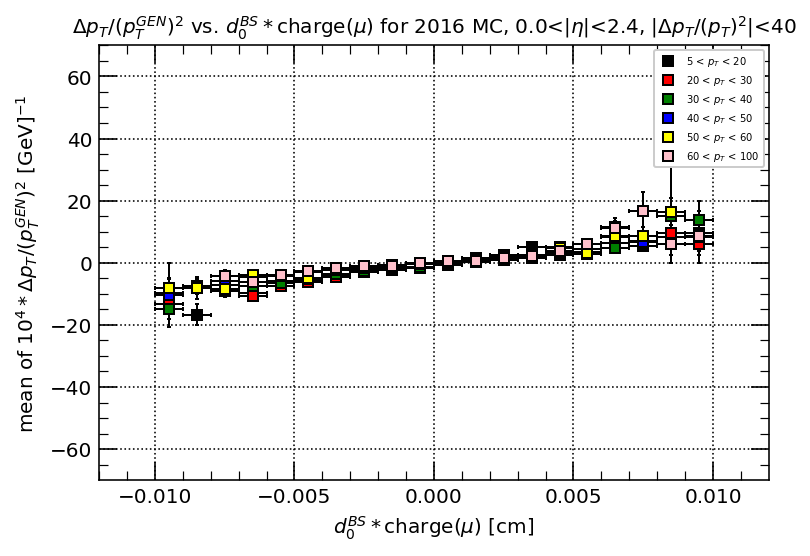

y_vals for graph_ls 1:
[-13.923731274856877, -9.352941221060444, -8.22674593056087, -3.248500469360671, -7.977946685578916, -8.15827230712314, -6.027936161578415, -4.633582123032491, -3.0555835386941084, -1.0452556695184376, 0.05386770235495291, 2.531506354878731, 2.6035242605721347, 5.999442001745805, 5.983621472584385, 10.143132204306454, 8.185577500985923, 5.30453195542693, 9.936595879497993, 0.6571053415801981]

y_vals for graph_ls 2:
[-11.243449847865918, -9.372097963234339, -10.082091764666236, -6.166390098302328, -5.1932915679736915, -6.234065680494097, -6.411684608525715, -4.347581235510334, -3.6358207987242146, -1.556143067325186, -0.2955763748680554, 1.1125287647271977, 2.222997516825155, 3.294425389902464, 4.033370081644079, 3.5265845215613645, 6.128457435538989, 8.294038594464723, 7.455020729248712, 11.711502302537824]

y_vals for graph_ls 3:
[-1.5478862656047532, -4.807163316590612, -7.886925991201087, -6.486718109202602, -6.627180734760386, -5.787830191294641, -6.05866811

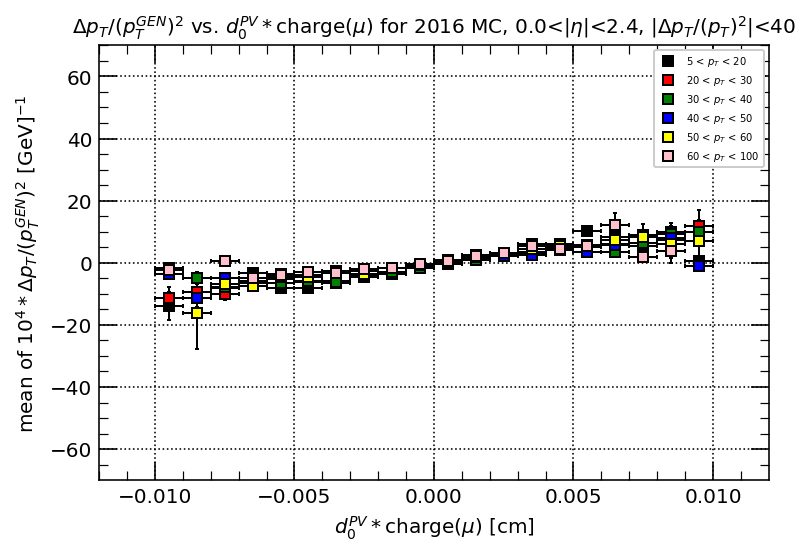

In [12]:
%config InlineBackend.figure_format ='retina'
make_graph(*BS_graphs_fulletarange, binning_type='pT', verbose=True, save_plots=True, outpath='/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/deltapT_vs_d0_plots/full_eta_spectrum_shoulder_cut/')
make_graph(*PV_graphs_fulletarange, binning_type='pT', verbose=True, save_plots=True, outpath='/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/deltapT_vs_d0_plots/full_eta_spectrum_shoulder_cut/')

## Below is for testing

In [ ]:
k=8
mask_ID_lep1 = toy_df_2016['Id1'] == 13
mask_ID_lep2 = toy_df_2016['Id2'] == 13

mask_d0BS_lep1 = (d0_bin_arr[k] < toy_df_2016['d0BS1']) & (toy_df_2016['d0BS1'] < d0_bin_arr[k+1])
mask_d0BS_lep2 = (d0_bin_arr[k] < toy_df_2016['d0BS2']) & (toy_df_2016['d0BS2'] < d0_bin_arr[k+1])

mask_pT1 = (20 < toy_df_2016['pT1']) & (toy_df_2016['pT1'] < 30)
mask_pT2 = (20 < toy_df_2016['pT2']) & (toy_df_2016['pT2'] < 30)

mask_eta1 = (0 < toy_df_2016['eta1']) & (toy_df_2016['eta1'] < 0.8)
mask_eta2 = (0 < toy_df_2016['eta2']) & (toy_df_2016['eta2'] < 0.8)

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])  # [low_left_corner_x, low_left_corner_y, width, height]

# ax.set_title(r"$\Delta p_{T}/p_{T}^2$")
ax.set_xlabel(r"$\Delta p_{T}/p_{T}^2$")
ax.set_ylabel(f"Events / [{deltapT_bin_width:.3f} GeV]")

ax.set_xlim([-300,300])

# toy_df_2016[mask_d0_lep1 & mask_eta1]['massZ'].hist(bins=100)
masked_df = toy_df_2016[(mask_ID_lep1 & mask_d0BS_lep1 & mask_eta1 & mask_pT1) | (mask_ID_lep2 & mask_d0BS_lep2 & mask_eta2 & mask_pT2)]
delta_pT_series1 = (masked_df.pT1 - masked_df.genLep_pt1) / masked_df.genLep_pt1**2 * 1E4
delta_pT_series2 = (masked_df.pT2 - masked_df.genLep_pt2) / masked_df.genLep_pt2**2 * 1E4


n_entries = len(delta_pT_series)
mean1 = delta_pT_series1.mean()
stdev1 = delta_pT_series1.std()

# From ROOT: mean error = StdDev / sqrt( Neff )

# Stats box.
textstr = '\n'.join((
    f'Entries = {n_entries}',
    f'Mean = {mean1:.3f}',
#     r'$\mu = %.2f$' % (mean, ),
#     r'$\mathrm{text that uses mathrm!}',
    f'Std Dev = {stdev1:.3f}',))
props = dict(boxstyle='round', facecolor='wheat')
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

delta_pT_series.hist(bins=deltapT_n_bins)

# Traditional tree.GetEntry() method.

In [ ]:
n_evts = 10000
f = ROOT.TFile.Open(inpath_file_MC_2016)
t = f.Get("passedEvents")

kinem = "pT1"
h = ROOT.TH1D("h_%s" % kinem, "h_%s" % kinem, 500, 0, 500)
for evt in range(n_evts):
    t.GetEntry(evt)
    if (evt % 100) == 0:
        print "Running on evt", evt, ". Collecting", kinem 
    h.Fill(t.kinem)
h.Draw()

# Old working code - now fragmented.

In [ ]:
                        #----- Plot the mll (Z peak) distribution. -----#
                        if (make_plots_mll_dist):

                            c_mll = ROOT.TCanvas()
                            c_mll.cd()

                            mll_cuts  = "(Id1 == %s && %s < d0%s1 && d0%s1 < %s && %s < eta1 && eta1 < %s) || " % (ID, this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str)
                            mll_cuts += "(Id2 == %s && %s < d0%s2 && d0%s2 < %s && %s < eta2 && eta2 < %s)"     % (ID, this_d0_str, bspv, bspv, next_d0_str, this_eta_str, next_eta_str)
                            if len(massZ_cut) != 0:
                                mll_cuts = "(" + mll_cuts + ")"
                                mll_cuts += " && %s" % (massZ_cut)

                            mll_hist_name = "h_mll_mu%s_%s__%s_eta_%s__%s_d0_%s" % (charge, bspv, this_eta_str, next_eta_str, this_d0_str, next_d0_str)
                            mll_hist_name = make_str_title_friendly(mll_hist_name)
                            h_mll = ROOT.TH1F(mll_hist_name, mll_cuts, mll_n_bins, mll_x_min, mll_x_max)
                #             h_mll_PV = ROOT.TH1F("h_mll", "muP_d0_PV", mll_n_bins, mll_x_min, mll_x_max)

                            # @@@@@ WARNING: this is just for 2016 file!!! @@@@@
                            t_2016.Draw("massZ >> %s"%mll_hist_name, mll_cuts, "")

                            h_mll.GetXaxis().SetTitle("m_{#mu^{+}#mu^{-}} [GeV]")
                            h_mll.GetYaxis().SetTitle("Events / [%.1f GeV]" % mll_bin_width)
                            h_mll.GetXaxis().SetTitleOffset(1.3)
                            h_mll.GetYaxis().SetTitleOffset(1.3)
                            # h1.SetAxisRange(0.0, 0.1, "X")   
                            # h1.SetLabelSize(0.03, "Y")                        
                            # h1.SetLineColor(1)
                            h_mll.Draw("hist 9 same")

                            c_mll.Draw()
                            # h1.Draw("e1 hist 9 same")

                            if (test_in_tier2):
                                title = 'mll_dist_MC%s_mu%s__%s_eta_%s__%s_d0%s_%s' % (year, charge, this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)
                                if len(massZ_cut) != 0: 
                                    title += "__" + massZ_cut
                                title = make_str_title_friendly(title)
                                fullpath = os.path.join(outpath_plots_mll, title)
                                c_mll.SaveAs(fullpath + '.png')
                                c_mll.SaveAs(fullpath + '.pdf')    

                            if (make_big_pdf):
                                title = ("mll_dist_MC%s_mu%s__%s_eta_%s__%s_d0%s_%s_increm%s" % (year, 
                                                                                                          charge,
                                                                                                          str(this_eta),
                                                                                                          str(next_eta),
                                                                                                          str(d0_min),
                                                                                                          str(bspv),
                                                                                                          str(d0_max),
                                                                                                          str(d0_bin_width))
                                        )
                                if len(massZ_cut) != 0: 
                                    title += title + massZ_cut                    
                                title = make_str_title_friendly(title)
                                fullpath = os.path.join(outpath_plots_mll, title)
                                if this_d0 == d0_min:
                                    c_mll.Print(fullpath + '.pdf[')
                                c_mll.Print(fullpath + '.pdf')
                                if next_d0 == d0_max:
                                    c_mll.Print(fullpath + '.pdf]')


                            # Extract mean, RMS, and store for later.
                            #--- FIXME! Implement a fit with CBxBW + exp
                            #--- FIXME! Implement a fit with Voigtian
                            if (make_plots_mllmean_vs_d0):
                                mean = h_mll.GetMean()
                                mean_err = h_mll.GetMeanError()
                                stdev = h_mll.GetStdDev()
                                stdev_err = h_mll.GetStdDevError()

                                mll_mean_list.append(mean)
                                mll_mean_err_list.append(mean_err)

                            if (verbose):
                                print "mll_mean_list:", mll_mean_list
                                print "mll_mean_err_list:", mll_mean_err_list
                                print "Completed %s<eta<%s, %s<d0%s<%s \n" % (this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)


                            # Extract mean, RMS, and store for later.
                            #--- FIXME! Implement a fit with CBxBW + exp
                            #--- FIXME! Implement a fit with Voigtian
                            if (make_plots_deltapT_vs_d0):
                                mean = h_deltapT.GetMean()
                                mean_err = h_deltapT.GetMeanError()
                                stdev = h_deltapT.GetStdDev()
                                stdev_err = h_deltapT.GetStdDevError()

                                deltapT_mean_list.append(mean)
                                deltapT_mean_err_list.append(mean_err)

                            if (verbose):
                                print "deltapT_mean_list:", deltapT_mean_list
                                print "deltapT_mean_err_list:", deltapT_mean_err_list
                                if binning_style in 'eta':
                                    print "Completed %s<pT<%s, %s<eta<%s, %s<d0%s<%s \n" % (pT_low_str, pT_high_str, this_eta_str, next_eta_str, this_d0_str, bspv, next_d0_str)
                                if binning_style in 'pT':
                                    print "Completed %s<pT<%s, %s<d0%s<%s \n" % (this_pT_str, next_pT_str, this_d0_str, bspv, next_d0_str)

                        # End of the first loop. Go to next d0 region.     

                    # Finished all d0 regions. 

                    if (make_plots_mllmean_vs_d0):
                        # Convert everything to arrays, if not already one.
                        mll_mean_arr = np.array(mll_mean_list)
                        mll_mean_err_arr = np.array(mll_mean_err_list)

                        if (verbose):
                            print "d0_n_bins:",d0_n_bins
                            print "len(d0_bin_arr_shifted):",len(d0_bin_arr_shifted)
                            print "mll_mean_arr:",mll_mean_arr
                            print "mll_mean_err_arr:",mll_mean_err_arr
                            print "    Finished with d0 array.\n\n"

                        # Making a TGraphErrors for this BS/PV, eta region or pT region, and d0_array.
                        graph = ROOT.TGraphErrors(d0_n_bins, d0_bin_arr_shifted, mll_mean_arr, d0_bin_err_arr, mll_mean_err_arr)
                        graph.this_eta = this_eta
                        graph.next_eta = next_eta
                        if binning_style in 'eta':
                            graph.this_pT = pT_low
                            graph.next_pT = pT_high                                   
                        if binning_style in 'pT':
                            graph.this_pT = this_pT
                            graph.next_pT = next_pT                            
                        graph.color = 1 + num
                        graph.bs_or_pv = bspv

                        if graph.bs_or_pv in 'BS':
                            graph_mll_bs_list.append(graph)
                        elif graph.bs_or_pv in 'PV':
                            graph_mll_pv_list.append(graph)
                        # User may only select 'BS', so other list may be empty. 

        #----- Make mllmean vs. d0 Plots. -----#
        if (make_plots_mllmean_vs_d0):
            print "...Making mean Zmass vs. d0 plots..."
            y_min_mll = min(graph_mll_bs_list + graph_mll_pv_list)
            y_max_mll = max(graph_mll_bs_list + graph_mll_pv_list)

            for graph_list in [graph_mll_bs_list, graph_mll_pv_list]:
                if len(graph_list) == 0: continue
                count = 0
                leg_mll = ROOT.TLegend(0.75,0.8,0.9,0.9)                                           
                c_mllvsd0 = ROOT.TCanvas()
                c_mllvsd0.cd()
                c_mllvsd0.Draw()

                for gr in graph_list:
                    gr.SetMarkerStyle(21)  # 5=X, 20=o, 21=square, 22=tri, 23=upside-down tri
                    gr.SetMarkerColor(2 + count)  # 1=kBlack, 2=kRed, 3=kGreen, 4=kBlue
                    gr.SetMinimum(87.0) 
                    gr.SetMaximum(95.0)
                    x_title = "d_{0}^{RECO, %s}(#mu^{%s}) [cm]" % (gr.bs_or_pv, charge)
            #         y_title = "mean m_{\\ell\\ell} \ [%.3f cm]" % (d0_bin_width)
                    y_title = "mean m_{#mu#mu} [GeV]" # / [%.3f cm]" % (d0_bin_width)
                    gr.SetTitle( "mean m_{#mu#mu} vs. d_{0}^{%s}(#mu^{%s}), %s MC" % (gr.bs_or_pv, charge, year) )
                    if len(massZ_cut) != 0:
                        gr.SetTitle += ", %s"%massZ_cut
                    gr.GetXaxis().SetTitle(x_title)
                    gr.GetYaxis().SetTitle(y_title)
                    gr.GetXaxis().SetTitleOffset(1.3)
                #     gr.GetYaxis().SetTitleOffset(1.3)

                    gr.Draw("ap") if count == 0 else gr.Draw('p same')
                #     gr.Draw("apl") 

                    leg_mll.AddEntry(gr,"%s < |#eta| < %s" % (str(gr.this_eta),str(gr.next_eta)),"lpe")  
                #     leg.AddEntry(h1,"%s < |#eta| < %s" % (str(this_eta),str(next_eta)),"lpf")                                                         
                #     leg.SetLineWidth(3)                                                       
                #     leg.SetBorderSize(0)                                                      
                #     leg.SetTextSize(0.03)    
                    leg_mll.Draw("same")                                  
                    count += 1

In [ ]:
# Example showing how to draw a histogram and then play with text boxes.
c1 = ROOT.TCanvas()
mystr = 'this is my title and Im gonna make it super long and see what happens'

# Must draw histo first, otherwise the pave objects will be deleted.
h1 = ROOT.TH1F('h_internal_name',"some clever title",50,0,100)
h1.Draw()

# I don't know the main difference between TPaveLabel and TPaveText.
# Right now I like TPaveText more because you can pavetext.AddText("More text appears!")
# Here you can see both in action:
pavelabel = ROOT.TPaveLabel(20,0.6,80,1.15, "#splitline{%s}{%s}" % (mystr,"a new string appears"))
pavelabel.SetTextSize(0.06)

# Pave objects stay within the axes.
# xmin=0 touches left axis, xmax=100 touches right axis.
# ymin=0 touches bottom axis but STRANGELY, ymax=1.05 touches top axis.
# TPaveText breaks when ymax > 1.15 ish.
pavetext = ROOT.TPaveText(0,0.05,25,0.4)
pavetext.SetFillColor(19)
pavetext.SetTextSize(0.025)
# pavetext.SetTextAlign(12)
pavetext.AddText("0 < p_{T} < 20")

# Control individual text objects.
txt = pavetext.AddText('#frac{LaTeX}{works} ')
txt.SetTextSize(0.030)

pavetext.Draw()
pavelabel.Draw()

c1.Draw()

# Jake's Old Framework

In [ ]:
    x = ROOT.RooRealVar("x","x",fit_x_min,fit_x_max)
    l = ROOT.RooArgList(x)
    data = ROOT.RooDataHist("data", "MC massZ values", l, h_dude)

    w = ROOT.RooWorkspace()

    Voigt_sig_str = 'Voigtian::v(x[%s,%s], my_mean[%s,%s,%s], my_width[%s,%s,%s], my_sigma[%s,%s,%s])' % (str(fit_x_min),
                                                                                                          str(fit_x_max), 
                                                                                                          str(h_mean),
                                                                                                          str(hist_mll_x_min),
                                                                                                          str(hist_mll_x_max),
                                                                                                          str(h_stdev),
                                                                                                          str(0),
                                                                                                          str(fit_x_max),
                                                                                                          str(h_stdev),
                                                                                                          str(0),
                                                                                                          str(fit_x_max),)

    Exp_bkg_str = 'Exponential::e(x,tau[%s,%s,%s])' % (str(-0.5),
                                                      str(-5), 
                                                      str(0),)

    Model_sigbkg_str = 'SUM::model(s[%s,%s,%s]*v,b[%s,%s,%s]*e)' % (str(1E5),
                                                                    str(0),
                                                                    str(1E7),
                                                                    str(1E5),
                                                                    str(0),
                                                                    str(1E7),)

    w.factory(Voigt_sig_str)
    w.factory(Exp_bkg_str)
    w.factory(Model_sigbkg_str)


    # w.factory('Voigtian::v(x[86,96], my_mean[90,70,120], my_width[8,0,20], my_sigma[8,0,20])' % )
    # w.factory('Exponential::e(x,tau[-0.5,-5,0])')
    # w.factory('SUM::model(s[1E5,0,1E7]*v,b[1E5,0,1E7]*e)')
    pdf = w.pdf('model')
    w.Print()

    frame = x.frame()
    fit_result = pdf.fitTo(data,
                           ROOT.RooFit.Save(),
                           ROOT.RooFit.PrintLevel(-1)
                          )
    data.plotOn(frame)
    pdf.plotOn(frame)
    c = ROOT.TCanvas()
    frame.Draw()

    if (verbose): 
        print "Fit range [GeV] =",[fit_x_min,fit_x_max]
        fit_result.Print()

    mll_mean = w.var("my_mean").getVal()
    mll_mean_err = w.var("my_mean").getError()

In [ ]:
def fit_with_voigt(hist, n_stdev, draw=False, fit_around_center="mean", combine_bins=1):
    """
    fit_with_voigt(hist, n_stdev, draw=False, fit_around_center="mean", combine_bins=1)

    Fits a single histogram (hist) with a voigtian (Gauss conv. with BW) + exp-falling background.
        Fit range: mu +- n_stdev*sigma
            mu = mean of hist
            sigma = stdev of hist
            n_stdev = number of sigmas

    Fit can be done centered at the mean (fit_around_mean=True) or around the peak 
    of the histogram (fit_around_mean=False).

    Returns
    -------
    mll_mean : float
    mll_mean_err : float
    """
    hist_list_tmp = []
    fit_list = []
    canvas_list = []
    n_dof_list = []

    canvas_list.append(TCanvas())
    hist_list_tmp.append( hist.Clone() )
    h_tmp = hist_list_tmp[-1]
#     h_tmp.mass = mass
    # print "mass is:",mass
    # print "h_tmp.mass is:",h_tmp.mass
    # if rebin > 1: 
    #     h_tmp.Rebin(rebin)
    bin_width = h_tmp.GetBinWidth(1)  # Select bin next to underflow bin, for safety.
    h_tmp.bin_width = bin_width
    h_tmp.n_sigmas = nstdev
    h_tmp.mean = h_tmp.GetMean()
    h_tmp.stdev = h_tmp.GetStdDev()

    h_tmp.bin_at_max = h_tmp.GetMaximumBin()
    h_tmp.most_prob_val = h_tmp.GetXaxis().GetBinCenter(h_tmp.bin_at_max)

    if fit_around_center in "mean":
        center = h_tmp.mean
        center_str = "mean"
        print "Fitting around mean."
    elif fit_around_center in "mpv":
        # Fit around the peak instead.
        center = h_tmp.most_prob_val
        center_str = "most_prob_val"
        print "Fitting around mean."
    else: 
        raise SyntaxError("Warning: fit_around_center parameter not understood.")

    fit_x_min = center - nstdev*h_tmp.stdev
    fit_x_max = center + nstdev*h_tmp.stdev
    fit_list.append( TF1("fit1","gaus",fit_x_min,fit_x_max) )
    fit_tmp = fit_list[-1]

    # Do the fit.
    h_tmp.params = h_tmp.Fit(fit_tmp,"SRQ")  # S=store_result, R=ranged_fit, Q=quiet 

    # Get parameters.
    params = h_tmp.params

    h_tmp.fit_const = params.Parameter(0) 
    h_tmp.fit_const_err = params.ParError(0)
    h_tmp.fit_mean = params.Parameter(1)
    h_tmp.fit_mean_err = params.ParError(1)
    h_tmp.fit_sigma = params.Parameter(2)
    h_tmp.fit_sigma_err = params.ParError(2)            
    h_tmp.chi2 = fit_tmp.GetChisquare()  # This returns TOTAL chi^2, not reduced!
    h_tmp.n_dof = fit_tmp.GetNDF()

    # Since I'm storing each h_tmp in a hist_fit_list, 
    # I probably don't need these lists below.
    # FIXME: which values do I want to save? 
    #     - the main histogram (self)?
    #     - the h_tmp, of which there will be many? <-- probably this one?
    #     - lists of all the individual variables (listed below)
    fit_const_list.append( h_tmp.fit_const )
    fit_const_err_list.append( h_tmp.fit_const_err )
    fit_mean_list.append( h_tmp.fit_mean )
    fit_mean_err_list.append( h_tmp.fit_mean_err ) 
    fit_sigma_list.append( h_tmp.fit_sigma )
    fit_sigma_err_list.append( h_tmp.fit_sigma_err )
    fit_rel_sigma_list.append( h_tmp.fit_sigma/float(h_tmp.mass) )
    fit_rel_sigma_err_list.append( h_tmp.fit_sigma_err/float(h_tmp.mass) )
    n_dof_list.append( h_tmp.n_dof )

    try:
        h_tmp.reduced_chi2 = h_tmp.chi2/float(h_tmp.n_dof)
    except ZeroDivisionError:
        h_tmp.reduced_chi2 = np.inf
    red_chi2_list.append( h_tmp.reduced_chi2 )

    if not (draw):
        gROOT.SetBatch(kTRUE)  # Prevent ROOT from drawing plots to screen.
    gStyle.SetOptFit(1111)
#             gStyle.SetStatX(-0.1)
#             gStyle.SetStatY
    h_tmp.SetXTitle("m_{X} [GeV]")
    h_tmp.SetYTitle( "Events / [%.3f GeV]" % h_tmp.bin_width )

    extra_title = "Fit range: [%s #pm %.2f*sigma]" % (center_str,nstdev)
    if h_tmp.GetName() in ["mZ2_4e","mZ2_2mu2e"]:
        h_tmp.SetTitle("X #rightarrow e^{-}e^{+}, " + extra_title)
    else:
        h_tmp.SetTitle("X #rightarrow #mu^{-}#mu^{+}, " + extra_title)

    h_tmp.Draw('hist e1')
    fit_tmp.Draw("same")
    canvas_list[-1].Update()
    canvas_list[-1].Draw()
    # Done with fit.

    # Save all info in object.
    hist_fit_list = hist_list_tmp
    fit_list = fit_list
    canvas_list = canvas_list
    n_stdev_list = n_stdev_list

    return mll_mean, mll_mean_err

# Hualin-Style Old Stuff

In [ ]:
import os, sys, shutil, string, re
import numpy as np

import ROOT
from ROOT import (TFile,TTree,TH1D,TCanvas,TGraphErrors,TSelector,TF1,TLatex,
                  kTRUE,kDashed,
                  gPad,gStyle,gROOT,gDirectory,
                  RooFit,RooRealVar,RooVoigtian,RooExponential,RooAddPdf,RooFitResult,
                  RooMsgService,RooDataSet,RooDataHist,RooWorkspace,RooArgSet,RooArgList)
from subprocess import call
from array import array

RooMsgService.instance().setStreamStatus(1,False);

# sys.path.append('/home/rosedj1/HiggsMeasurement/')
# sys.path.append('/home/rosedj1/HiggsMeasurement/CMSSW_8_0_32/src/PyUtils/')

In [ ]:
class MllHistFit:
    def __init__(self,
                 fs,
                 d0_range,
                 inpath_file,
                 inpath_selector,
                 outpath,
                 massZ_lo,
                 massZ_hi,
                 bin_width,
                 n_bins_ZErr,
                 extra_cuts="",
                 make_new_selector=False
                 ): 
        """
        
        Create a histogram to be manipulated using user-defined methods.
        
        Parameters:
        -----------
        fs : str
            Final state.
        d0_range : array_like
            [initial_d0, final_d0]
        inpath_file : str
            Input file path.
        inpath_selector : str
            Input file path of selector, excluding file itself.
        outpath : str
            Output file path.
        massZ_lo : float
            Lower-bound of mll plot.
        massZ_hi : float
            Upper-bound of mll plot.
        bin_width : float
            Bin width for all bins.
        n_bins_ZErr : int
            Number of bins to use in ZErr analysis.
        extra_cuts : string, optional
            Cuts to apply to each event. Default = "".
        make_new_selector : bool
            If false (default) will NOT make_new_selector MySelector(.C,.h) found in inpath_file
        
        Returns
        -------
        Nothing yet.
        """
        self.fs = fs
        self.d0_range = d0_range
        self.inpath_file = inpath_file
        self.outpath = outpath
        self.massZ_lo = massZ_lo
        self.massZ_hi = massZ_hi
        self.bin_width = bin_width
        self.n_bins_ZErr = n_bins_ZErr 
        
        self.n_bins = -1
        self.name = "Testy_boi"
        self.cuts = ""
        
        #----- Automatic stuff -----#
        d0_min = d0_range[0]
        d0_max = d0_range[1]
        self.n_bins = int(round( (massZ_hi-massZ_lo)/bin_width ))

        
        # Apply massZ cuts.
        self.cuts += "%s < massZ && massZ < %s && " % (str(massZ_lo), str(massZ_hi))
        
        # Apply d0 cuts.
        self.cuts += "%s < d0BS1 && d0BS1 < %s && " % (str(d0_min), str(d0_max))
        self.cuts += "%s < d0BS2 && d0BS2 < %s"    % (str(d0_min), str(d0_max))
        
        if extra_cuts not in "": 
            self.cuts += " && " + extra_cuts
        
        # Access file and tree info.
        self.file = TFile(inpath_file)
        self.tree = self.file.Get("passedEvents")
        print 'tree opened'
        
        # Make dataset objects and a histogram object to store data.
        self.Data_Zlls = RooDataSet()
        self.Data_Zlls_w = RooDataSet()
        self.Data_Zlls_binned = RooDataHist()

        self.w = RooWorkspace("w","workspace")
#         print "Workspace after initialization:\n",self.w.Print()
            
        # Holds the input and output of a PDF fit to a dataset.
        self.fit_result = RooFitResult() 
        
    #---------------------------------------------------------------------#
    def prepare_dataset(self):
        # I'm a little confused... I thought that RooRealVar massZ was defined here,
        # but instead Hualin defines it in the next method, "combine_pdfs"...
        # Maybe it doesn't matter.
        
        self.tree.Draw(">>myList", self.cuts, "entrylist")
        # I think SetEntryList has something to do with PROOF and parallel processing.
        entryList = gDirectory.Get("myList")
        self.tree.SetEntryList(entryList)
        
         # Make selector object.
#         cwd = os.environ['PWD']
        selector_path = inpath_selector
        selector_name = "MySelector"
        fullpath_selector = os.path.join(selector_path,selector_name+".C")
        if not os.path.exists(fullpath_selector) and (make_new_selector):
            print "Making new selector file:", 
            self.tree.MakeSelector(selector_name)
        self.selector = TSelector.GetSelector(fullpath_selector)
        
        # These methods are defined in MySelector.C and called here.
        self.selector.SetNumBins(self.n_bins)
        self.selector.SetNumBins_ZErr(self.n_bins_ZErr)
        self.selector.SetRange_massZ(self.massZ_lo, self.massZ_hi)
        self.selector.SetRange_massZErr(0, 999)
#         selector.SetLambda( int(self.doLambda1), self.Lambdas["lambda1"], self.Lambdas["lambda2"] )

#       These variables are from MySelector.h. Putting them here for easy reference. 
#         rv_weight   = new RooRealVar("weight","weight", 0.00001, 100);
#         rv_massZ    = new RooRealVar("massZ","massZ", massZ_lo, massZ_hi);
#         rv_massZErr = new RooRealVar("massZErr","massZErr", massZErr_lo, massZErr_hi);
#         rastmp      = new RooArgSet(*rv_massZ, *rv_massZErr, *rv_weight);
#         Data_Zlls   = new RooDataSet("Zlls","Zlls", *rastmp);
#         massZ = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
#         massZErr = RooRealVar("massZErr","massZErr", self.massZErr_lo, self.massZErr_hi)

#         for key,val in self.shapePara.items():
#             print key,":",val

        # This is the big boy: run the Process method.
        # Go event by event in the tree and grab everything defined in 
        # the Process() section of MySelector.C.
        self.tree.Process(self.selector)
        
        self.Data_Zlls = self.selector.Data_Zlls # Store the values in a RooDataSet called Data_Zlls
        # Use Data_Zlls dataset to make a new WEIGHTED dataset.
        self.Data_Zlls_w = RooDataSet(self.Data_Zlls.GetName(), self.Data_Zlls.GetTitle(), self.Data_Zlls, self.Data_Zlls.get(), "1", "weight")
        print "RooDataSet Data_Zlls_w after cuts has " + str(self.Data_Zlls_w.numEntries()) + " events.\n"
        print "Cuts applied:\n", self.cuts

#         self.Data_Zlls_binned = self.Data_Zlls_w.binnedClone()
        
#         return self.w, self.Data_Zlls_w
        
        
        #---------------------------------------------------------------------#
    def combine_pdfs(self):
        """
        Creates the different PDFs (Voigtian signal, Exp bkg) and combines them into a "model".
        """
        massZ    = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
        massZErr = RooRealVar("massZErr","massZErr", 0,-10,10)
        mean = RooRealVar("mean","#mu",0,-5,5)  # Gaus and BW share the same mean!
        gaus_sigma = RooRealVar("gaus_sigma","#sigma_{gaus}",0,-5,5)
#         bw_mean = RooRealVar("bw_mean","#mu_{BW}",0,999)
        bw_width = RooRealVar("bw_width","#Gamma_{BW}",0,-5,5)
#         BW = RooBreitWigner("BW","Breit Wigner theory", massZ, breitWignerMean,breitWignerGamma)
#         breitWignerMean   = RooRealVar("breitWignerMean", "m_{Z^{0}}", self.GENZ_mean)
#         breitWignerGamma  = RooRealVar("breitWignerGamma", "#Gamma", self.GENZ_width)
#         breitWignerGamma.setConstant(kTRUE)
#         breitWignerMean.setConstant(kTRUE)
        tau = RooRealVar("tau","#tau",-1,1)
#         coeff = RooRealVar("coeff","coeff",0,-5,5)
        nsig = RooRealVar("nsig","#signal events",10000,0.,100000);
        nbkg = RooRealVar("nbkg","#background events",10000,0.,100000);
        # voigtian = BWxGaussian: const char* name, const char* title, RooAbsReal& _x, RooAbsReal& _mean, RooAbsReal& _width, RooAbsReal& _sigma, Bool_t doFast = kFALSE
        voigt = RooVoigtian("sig","sig", massZ, mean, bw_width, gaus_sigma)  # I believe this does the convolution on its own.
        exp = RooExponential("bkg","bkg",massZ, tau)
        
        #pa2 = RooRealVar("pa2","pa2", 0.0098, -10,10)
        #p2 = RooFormulaVar("p2", "@1*@0+@2*@0*@0",RooArgList(massZ,pa1,pa2)) # may not be used
        
        model = RooAddPdf("model","sig_plus_bkg_model",RooArgList(voigt, exp), RooArgList(nsig,nbkg))
        getattr(self.w,'import')(model) # same as doing: object.attribute
        
#------------------------------------------------------------------------------#      
    def do_fit(self):
        print "Number of entries in workspace Dat_Zlls_w:", self.Data_Zlls_w.numEntries()
        if self.Data_Zlls_w.numEntries() < 5000:
            print "Using an UN-binned fit."
#             mZ = self.w.var("massZ")
#             pdf_sum = self.pdf("model")
#             frame = mZ.frame()
#             data = pdf.generate(RooArgSet(mZ))
#             data.plotOn(frame)
#             fitResult = pdf.fitTo(data,RooFit.Save(),RooFit.PrintLevel(-1))
#             pdf.plotOn(frame)
#             frame.Draw()
            self.fit_result = self.w.pdf("model").fitTo(self.Data_Zlls_w, 
                                                        RooFit.Save(kTRUE), 
                                                        RooFit.SumW2Error(kTRUE), 
                                                        RooFit.PrintLevel(-1), 
                                                        RooFit.Timer(kTRUE)
                                                        )
#         else: 
#             print "Using a binned fit."
#             self.rFit = self.w.pdf("model").fitTo(self.Data_Zlls_binned, 
#                                                   RooFit.Save(kTRUE), 
#                                                   RooFit.SumW2Error(kTRUE), 
#                                                   RooFit.PrintLevel(-1), 
#                                                   RooFit.Timer(kTRUE)
#                                                   )

#------------------------------------------------------------------------------#      
    def get_params_from_fit(self):
        pass
    
    def plot_fit(self, outpath, save_plots=False):
        # Make a plotting frame (essentially a canvas).
        title_offset = 1.3
        
        PmassZ = self.w.var("massZ").frame(RooFit.Bins(self.n_bins))
        PmassZ.GetXaxis().SetTitle("m_{l^{+}l^{-}} [GeV]")
#          PmassZ.GetXaxis().SetTitle("m_{\\ell\\ell}\\ [GeV]")
        PmassZ.GetXaxis().SetTitleOffset(title_offset)
        PmassZ.GetYaxis().SetTitleOffset(title_offset)
    
        # Add the data to the plot.
        self.Data_Zlls_w.plotOn(PmassZ)
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.ProjWData(self.Data_Zlls_w, kTRUE),
                                   RooFit.LineColor(2), 
                                   RooFit.LineWidth(1),
                                   )
        
        # Add a box with parameters values to the frame.
        self.w.pdf("model").paramOn(PmassZ, 
                                    RooFit.Layout(0.17, 0.47, 0.9), 
                                    RooFit.Format("NE", RooFit.FixedPrecision(4))
                                    )
        
#         PmassZ.getAttText().SetTextSize(0.03)

        # Retrieve chi^2 test on the massZ fit
        # Also return a list of floating parameters after fit
#         chi2 = PmassZ.chiSquare(self.fit_result.floatParsFinal().getSize())
#         dof =  self.fit_result.floatParsFinal().getSize()

        # Draw the bkg and signal models???
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.Components("bkg"), 
                                   RooFit.LineStyle(kDashed)
                                   )
        self.Data_Zlls_w.plotOn(PmassZ)
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.ProjWData(self.Data_Zlls_w,kTRUE),
                                   RooFit.LineColor(2), 
                                   RooFit.LineWidth(1) 
                                   )
        
        
#         ch = TCanvas("ch","ch",1000,800)
        ch = TCanvas()
        ch.cd()

        PmassZ.Draw("")

        latex = TLatex()
        latex.SetNDC()
#         latex.SetTextSize(0.55*ch.GetTopMargin())
#         latex.SetTextFont(42)
#         latex.SetTextAlign(11)

        # DrawLatex(xcoord, ycoord, "text")
#         latex.DrawLatex(0.70, 0.85, "#chi^{2}/DOF = %.3f" %(chi2/float(dof)))    
        latex.DrawLatex(0.70, 0.8, "mean = %.3f" %(self.w.var("mean").getVal()))
        latex.DrawLatex(0.70, 0.75, "#sigma_{gaus} = %.3f" %(self.w.var("gaus_sigma").getVal()))        
        latex.DrawLatex(0.70, 0.7, "BW width = %.3f" %(self.w.var("bw_width").getVal()))
        latex.DrawLatex(0.70, 0.65, "nsig = %d" %(self.w.var("nsig").getVal()))
        latex.DrawLatex(0.70, 0.60, "nbkg = %d" %(self.w.var("nbkg").getVal()))
        latex.DrawLatex(0.70, 0.55, "#tau = %.3f" %(self.w.var("tau").getVal()))

#         latex.DrawLatex(0.70, 0.65, "n = %.3f" %(self.w.var("n").getVal()))
#         latex.DrawLatex(0.75, 0.65, "pa1 = %.3f" %(self.w.var("pa1").getVal()))
#         latex.DrawLatex(0.75, 0.6, "pa2 = %.3f" %(self.w.var("pa2").getVal()))
#         latex.DrawLatex(0.75, 0.55, "#sigma_{CB} = %.3f" %(self.w.function("sigma").getVal()))

        if (save_plots):
            plot_name = os.path.join(outpath,self.name)
            ch.SaveAs(plot_name + '.png')
            ch.SaveAs(plot_name + '.pdf')

#         return PmassZ, chi2, dof, ch, latex

In [ ]:
mll_hist_fit_list = []
mll_hist_fit_list.append( MllHistFit(fs,
                                     d0_range_list,
                                     inpath_file,
                                     inpath_selector,
                                     outpath_mll_fit_plots,
                                     mll_x_min,
                                     mll_x_max,
                                     mll_bin_width,
                                     n_bins_ZErr,
                                     cuts,
                                     make_new_selector,) 
                        )

mll_plot1 = mll_hist_fit_list[-1]

# Play with histogram object.
mll_plot1.prepare_dataset()
mll_plot1.combine_pdfs()  # Hualin called this "MakeModel_getLambda".
# print "workspace before the fit:",mll_plot1.w.Print()
mll_plot1.do_fit()
# print "workspace after the fit:",mll_plot1.w.Print()
# # PmassZ, chi2, dof, ch, latex = mll_plot1.plot_fit(outpath_mll_fit_plots, save_plots)
mll_plot1.plot_fit(outpath_mll_fit_plots, save_plots)

## The next section came from an old Voigt.ipynb
Most likely it doesn't work out of the box, 
but some may be salvageable. 

In [ ]:
import os, sys, shutil, string, re
import numpy as np

from ROOT import (TFile,TTree,TH1D,TCanvas,TGraphErrors,TSelector,TF1,TLatex,
                  kTRUE,kDashed,
                  gPad,gStyle,gROOT,gDirectory,
                  RooFit,RooRealVar,RooVoigtian,RooExponential,RooAddPdf,RooFitResult,
                  RooMsgService,RooDataSet,RooDataHist,RooWorkspace,RooArgSet,RooArgList)
from subprocess import call
from array import array

RooMsgService.instance().setStreamStatus(1,False);

# sys.path.append('/home/rosedj1/HiggsMeasurement/')
# sys.path.append('/home/rosedj1/HiggsMeasurement/CMSSW_8_0_32/src/PyUtils/')

#---------------------------#
#----- User Parameters -----# 
#---------------------------#
plotname_d0_histo = "d0_PV_lead_mu"
# plotname_mll_fit = "mllfitgaus_no_d0_cuts"
plotname_mll_fit = "mllfit_voigt"

inpath_file = "/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/provad0_2mu.root"
inpath_selector = "/home/rosedj1/HiggsMeasurement/CMSSW_10_2_15/src/HiggsMassMeasurement/d0_Studies"

outpath_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/"
outpath_mll_fit_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/mll_fits/"
php_file = "/home/rosedj1/index.php"

make_new_selector = False
draw_plots = False # To the screen.
save_plots = True  # As pdf and png.

fs = "2mu"
d0_bin_width = 0.001
mll_bin_width = 0.2  #GeV

mll_x_min = 86  # GeV
mll_x_max = 96  # GeV

n_bins_ZErr = 100
cuts = ""
#cuts = "0 < abs(eta1) && abs(eta1) < 0.9 && 0 < abs(eta2) && abs(eta2) < 0.9"

# d0_range_list = list(np.arange(d0_min,d0_max*1.0000001,d0_bin_width))
d0_range_list = [0.0, 0.001]

mll_hist_fit_list = []

#--------------------------#
class MllHistFit:
    def __init__(self,
                 fs,
                 d0_range,
                 inpath_file,
                 inpath_selector,
                 outpath,
                 massZ_lo,
                 massZ_hi,
                 bin_width,
                 n_bins_ZErr,
                 extra_cuts="",
                 make_new_selector=False
                 ): 
        """
        
        Create a histogram to be manipulated using user-defined methods.
        
        Parameters:
        -----------
        fs : str
            Final state.
        d0_range : array_like
            [initial_d0, final_d0]
        inpath_file : str
            Input file path.
        inpath_selector : str
            Input file path of selector, excluding file itself.
        outpath : str
            Output file path.
        massZ_lo : float
            Lower-bound of mll plot.
        massZ_hi : float
            Upper-bound of mll plot.
        bin_width : float
            Bin width for all bins.
        n_bins_ZErr : int
            Number of bins to use in ZErr analysis.
        extra_cuts : string, optional
            Cuts to apply to each event. Default = "".
        make_new_selector : bool
            If false (default) will NOT make_new_selector MySelector(.C,.h) found in inpath_file
        
        Returns
        -------
        Nothing yet.
        """
        self.fs = fs
        self.d0_range = d0_range
        self.inpath_file = inpath_file
        self.outpath = outpath
        self.massZ_lo = massZ_lo
        self.massZ_hi = massZ_hi
        self.bin_width = bin_width
        self.n_bins_ZErr = n_bins_ZErr 
        
        self.n_bins = -1
        self.name = "Stupid_Plot_will_not_fit_right"
        self.cuts = ""
        
        #----- Automatic stuff -----#
        d0_min = d0_range[0]
        d0_max = d0_range[1]
        self.n_bins = int(round( (massZ_hi-massZ_lo)/bin_width ))

        
        # Apply massZ cuts.
        self.cuts += "%s < massZ && massZ < %s && " % (str(massZ_lo), str(massZ_hi))
        
        # Apply d0 cuts.
        self.cuts += "%s < d0BS1 && d0BS1 < %s && " % (str(d0_min), str(d0_max))
        self.cuts += "%s < d0BS2 && d0BS2 < %s"    % (str(d0_min), str(d0_max))
        
        if extra_cuts not in "": 
            self.cuts += " && " + extra_cuts
        
        # Access file and tree info.
        self.file = TFile(inpath_file)
        self.tree = self.file.Get("passedEvents")
        print 'tree opened'
        
        # Make dataset objects and a histogram object to store data.
        self.Data_Zlls = RooDataSet()
        self.Data_Zlls_w = RooDataSet()
        self.Data_Zlls_binned = RooDataHist()

        self.w = RooWorkspace("w","workspace")
#         print "Workspace after initialization:\n",self.w.Print()
            
        # Holds the input and output of a PDF fit to a dataset.
        self.fit_result = RooFitResult() 
        
    #---------------------------------------------------------------------#
    def prepare_dataset(self):
        # I'm a little confused... I thought that RooRealVar massZ was defined here,
        # but instead Hualin defines it in the next method, "combine_pdfs"...
        # Maybe it doesn't matter.
        
        self.tree.Draw(">>myList", self.cuts, "entrylist")
        # I think SetEntryList has something to do with PROOF and parallel processing.
        entryList = gDirectory.Get("myList")
        self.tree.SetEntryList(entryList)
        
         # Make selector object.
#         cwd = os.environ['PWD']
        selector_path = inpath_selector
        selector_name = "MySelector"
        fullpath_selector = os.path.join(selector_path,selector_name+".C")
        if not os.path.exists(fullpath_selector) and (make_new_selector):
            print "Making new selector file:", 
            self.tree.MakeSelector(selector_name)
        self.selector = TSelector.GetSelector(fullpath_selector)
        
        # These methods are defined in MySelector.C and called here.
        self.selector.SetNumBins(self.n_bins)
        self.selector.SetNumBins_ZErr(self.n_bins_ZErr)
        self.selector.SetRange_massZ(self.massZ_lo, self.massZ_hi)
        self.selector.SetRange_massZErr(0, 999)
#         selector.SetLambda( int(self.doLambda1), self.Lambdas["lambda1"], self.Lambdas["lambda2"] )

#       These variables are from MySelector.h. Putting them here for easy reference. 
#         rv_weight   = new RooRealVar("weight","weight", 0.00001, 100);
#         rv_massZ    = new RooRealVar("massZ","massZ", massZ_lo, massZ_hi);
#         rv_massZErr = new RooRealVar("massZErr","massZErr", massZErr_lo, massZErr_hi);
#         rastmp      = new RooArgSet(*rv_massZ, *rv_massZErr, *rv_weight);
#         Data_Zlls   = new RooDataSet("Zlls","Zlls", *rastmp);
#         massZ = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
#         massZErr = RooRealVar("massZErr","massZErr", self.massZErr_lo, self.massZErr_hi)

#         for key,val in self.shapePara.items():
#             print key,":",val

        # This is the big boy: run the Process method.
        # Go event by event in the tree and grab everything defined in 
        # the Process() section of MySelector.C.
        self.tree.Process(self.selector)
        
        self.Data_Zlls = self.selector.Data_Zlls # Store the values in a RooDataSet called Data_Zlls
        # Use Data_Zlls dataset to make a new WEIGHTED dataset.
        self.Data_Zlls_w = RooDataSet(self.Data_Zlls.GetName(), self.Data_Zlls.GetTitle(), self.Data_Zlls, self.Data_Zlls.get(), "1", "weight")
        print "RooDataSet Data_Zlls_w after cuts has " + str(self.Data_Zlls_w.numEntries()) + " events.\n"
        print "Cuts applied:\n", self.cuts

#         self.Data_Zlls_binned = self.Data_Zlls_w.binnedClone()
        
#         return self.w, self.Data_Zlls_w
        
        
        #---------------------------------------------------------------------#
    def combine_pdfs(self):
        """
        Creates the different PDFs (Voigtian signal, Exp bkg) and combines them into a "model".
        """
        massZ    = RooRealVar("massZ","massZ", self.massZ_lo, self.massZ_hi)
        massZErr = RooRealVar("massZErr","massZErr", 0,-10,10)
        mean = RooRealVar("mean","#mu",0,-5,5)  # Gaus and BW share the same mean!
        gaus_sigma = RooRealVar("gaus_sigma","#sigma_{gaus}",0,-5,5)
#         bw_mean = RooRealVar("bw_mean","#mu_{BW}",0,999)
        bw_width = RooRealVar("bw_width","#Gamma_{BW}",0,-5,5)
#         BW = RooBreitWigner("BW","Breit Wigner theory", massZ, breitWignerMean,breitWignerGamma)
#         breitWignerMean   = RooRealVar("breitWignerMean", "m_{Z^{0}}", self.GENZ_mean)
#         breitWignerGamma  = RooRealVar("breitWignerGamma", "#Gamma", self.GENZ_width)
#         breitWignerGamma.setConstant(kTRUE)
#         breitWignerMean.setConstant(kTRUE)
        tau = RooRealVar("tau","#tau",-1,1)
#         coeff = RooRealVar("coeff","coeff",0,-5,5)
        nsig = RooRealVar("nsig","#signal events",10000,0.,100000);
        nbkg = RooRealVar("nbkg","#background events",10000,0.,100000);
        # voigtian = BWxGaussian: const char* name, const char* title, RooAbsReal& _x, RooAbsReal& _mean, RooAbsReal& _width, RooAbsReal& _sigma, Bool_t doFast = kFALSE
        voigt = RooVoigtian("sig","sig", massZ, mean, bw_width, gaus_sigma)  # I believe this does the convolution on its own.
        exp = RooExponential("bkg","bkg",massZ, tau)
        
        #pa2 = RooRealVar("pa2","pa2", 0.0098, -10,10)
        #p2 = RooFormulaVar("p2", "@1*@0+@2*@0*@0",RooArgList(massZ,pa1,pa2)) # may not be used
        
        model = RooAddPdf("model","sig_plus_bkg_model",RooArgList(voigt, exp), RooArgList(nsig,nbkg))
        getattr(self.w,'import')(model) # same as doing: object.attribute
        
#------------------------------------------------------------------------------#      
    def do_fit(self):
        print "Number of entries in workspace Dat_Zlls_w:", self.Data_Zlls_w.numEntries()
        if self.Data_Zlls_w.numEntries() < 5000:
            print "Using an UN-binned fit."
#             mZ = self.w.var("massZ")
#             pdf_sum = self.pdf("model")
#             frame = mZ.frame()
#             data = pdf.generate(RooArgSet(mZ))
#             data.plotOn(frame)
#             fitResult = pdf.fitTo(data,RooFit.Save(),RooFit.PrintLevel(-1))
#             pdf.plotOn(frame)
#             frame.Draw()
            self.fit_result = self.w.pdf("model").fitTo(self.Data_Zlls_w, 
                                                        RooFit.Save(kTRUE), 
                                                        RooFit.SumW2Error(kTRUE), 
                                                        RooFit.PrintLevel(-1), 
                                                        RooFit.Timer(kTRUE)
                                                        )
#         else: 
#             print "Using a binned fit."
#             self.rFit = self.w.pdf("model").fitTo(self.Data_Zlls_binned, 
#                                                   RooFit.Save(kTRUE), 
#                                                   RooFit.SumW2Error(kTRUE), 
#                                                   RooFit.PrintLevel(-1), 
#                                                   RooFit.Timer(kTRUE)
#                                                   )

#------------------------------------------------------------------------------#      
    def get_params_from_fit(self):
        pass
    
    def plot_fit(self, outpath, save_plots=False):
        # Make a plotting frame (essentially a canvas).
        title_offset = 1.3
        
        PmassZ = self.w.var("massZ").frame(RooFit.Bins(self.n_bins))
        PmassZ.GetXaxis().SetTitle("m_{l^{+}l^{-}} [GeV]")
#          PmassZ.GetXaxis().SetTitle("m_{\\ell\\ell}\\ [GeV]")
        PmassZ.GetXaxis().SetTitleOffset(title_offset)
        PmassZ.GetYaxis().SetTitleOffset(title_offset)
    
        # Add the data to the plot.
        self.Data_Zlls_w.plotOn(PmassZ)
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.ProjWData(self.Data_Zlls_w, kTRUE),
                                   RooFit.LineColor(2), 
                                   RooFit.LineWidth(1),
                                   )
        
        # Add a box with parameters values to the frame.
        self.w.pdf("model").paramOn(PmassZ, 
                                    RooFit.Layout(0.17, 0.47, 0.9), 
                                    RooFit.Format("NE", RooFit.FixedPrecision(4))
                                    )
        
#         PmassZ.getAttText().SetTextSize(0.03)

        # Retrieve chi^2 test on the massZ fit
        # Also return a list of floating parameters after fit
#         chi2 = PmassZ.chiSquare(self.fit_result.floatParsFinal().getSize())
#         dof =  self.fit_result.floatParsFinal().getSize()

        # Draw the bkg and signal models???
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.Components("bkg"), 
                                   RooFit.LineStyle(kDashed)
                                   )
        self.Data_Zlls_w.plotOn(PmassZ)
        self.w.pdf("model").plotOn(PmassZ, 
                                   RooFit.ProjWData(self.Data_Zlls_w,kTRUE),
                                   RooFit.LineColor(2), 
                                   RooFit.LineWidth(1) 
                                   )
        
        
#         ch = TCanvas("ch","ch",1000,800)
        ch = TCanvas()
        ch.cd()

        if not (draw_plots): gROOT.SetBatch(kTRUE)
        PmassZ.Draw("")

        latex = TLatex()
        latex.SetNDC()
#         latex.SetTextSize(0.55*ch.GetTopMargin())
#         latex.SetTextFont(42)
#         latex.SetTextAlign(11)

        # DrawLatex(xcoord, ycoord, "text")
#         latex.DrawLatex(0.70, 0.85, "#chi^{2}/DOF = %.3f" %(chi2/float(dof)))    
        latex.DrawLatex(0.70, 0.8, "mean = %.3f" %(self.w.var("mean").getVal()))
        latex.DrawLatex(0.70, 0.75, "#sigma_{gaus} = %.3f" %(self.w.var("gaus_sigma").getVal()))        
        latex.DrawLatex(0.70, 0.7, "BW width = %.3f" %(self.w.var("bw_width").getVal()))
        latex.DrawLatex(0.70, 0.65, "nsig = %d" %(self.w.var("nsig").getVal()))
        latex.DrawLatex(0.70, 0.60, "nbkg = %d" %(self.w.var("nbkg").getVal()))
        latex.DrawLatex(0.70, 0.55, "#tau = %.3f" %(self.w.var("tau").getVal()))

#         latex.DrawLatex(0.70, 0.65, "n = %.3f" %(self.w.var("n").getVal()))
#         latex.DrawLatex(0.75, 0.65, "pa1 = %.3f" %(self.w.var("pa1").getVal()))
#         latex.DrawLatex(0.75, 0.6, "pa2 = %.3f" %(self.w.var("pa2").getVal()))
#         latex.DrawLatex(0.75, 0.55, "#sigma_{CB} = %.3f" %(self.w.function("sigma").getVal()))

        if (save_plots):
            plot_name = os.path.join(outpath,self.name)
            ch.SaveAs(plot_name + '.png')
            ch.SaveAs(plot_name + '.pdf')

#         return PmassZ, chi2, dof, ch, latex

#--------------------------------------------#
#----- Fit m_ll peak with voigtian+exp. -----#
#--------------------------------------------#
mll_hist_fit_list.append( MllHistFit(fs,
                                     d0_range_list,
                                     inpath_file,
                                     inpath_selector,
                                     outpath_mll_fit_plots,
                                     mll_x_min,
                                     mll_x_max,
                                     mll_bin_width,
                                     n_bins_ZErr,
                                     cuts,
                                     make_new_selector,) 
                        )

mll_plot1 = mll_hist_fit_list[-1]

# Play with histogram object.
mll_plot1.prepare_dataset()
mll_plot1.combine_pdfs()  # Hualin called this "MakeModel_getLambda".
# print "workspace before the fit:",mll_plot1.w.Print()
mll_plot1.do_fit()
# print "workspace after the fit:",mll_plot1.w.Print()
# # PmassZ, chi2, dof, ch, latex = mll_plot1.plot_fit(outpath_mll_fit_plots, save_plots)
mll_plot1.plot_fit(outpath_mll_fit_plots, save_plots)

In [ ]:
class MyHist:
    """
    Each MyHist object should be associated with only one histogram (hist). 
    The purpose of a MyHist is to create methods which can operate on the associated hist.
    
    After many hours, I have concluded that the tree.Draw("branch>>hist") method 
    cannot save hist persistently, i.e. return it via a function or save it in 
    something like self.my_hist. 
    
    So instead I will just save the drawn hist on a canvas and 
    all important information about the hist in a MyHist object.
    
    FUTURE_IMPLEMENTATION: 
     - Save the generated hist in a root file for later access.
    """
    
    def __init__(self, 
                 inpath_file, 
                 path_to_tree, 
                 x_min, 
                 x_max, 
                 bin_width, 
                 cut_list, 
                 branch, 
                 verbose=False,
                 draw_plots=False,
                 save_plots=False):        
        
        self.inpath_file = inpath_file
        self.path_to_tree = path_to_tree
        self.x_min = x_min
        self.x_max = x_max
        self.bin_width = bin_width
        self.cut_list = cut_list
        self.branch = branch
        
        self.n_bins = -1
        self.cut_str = ''
        self.canvas = None
        
        f = ROOT.TFile.Open(inpath_file)
        t = f.Get(path_to_tree)
        
        self.n_bins = int(round( (self.x_max - self.x_min)/self.bin_width ))

        # Apply cuts.
#         cut_massZ = "%s < massZ && massZ < %s" % (str(mll_x_min), str(mll_x_max))
        self.combine_cut_list()
#         if (verbose): 
#             print "Tree found."
#             print "hist created:", hist
#             print "cut_str:", self.cut_str
        
        c = ROOT.TCanvas()        
        c.cd()
        h1 = ROOT.TH1F("newhist","Z peak",self.n_bins, self.x_min, self.x_max)
#         t.Draw(self.branch + ">>newhist(%s,%s,%s)" % (self.n_bins, self.x_min, self.x_max), self.cut_str, "goff") 
        t.Draw(self.branch + ">>newhist", self.cut_str, "goff") 
#         self.hist = ROOT.gDirectory.Get("newhist")    # WON'T BE SAVED AT THE END! :-(

        if not (draw_plots):
            ROOT.gROOT.SetBatch(ROOT.kTRUE)
        h1.Draw("e1 hist 9 same")
#         c.Modified()
#         c.Update()
        c.Draw()

#----- FIXME: 
#----- Only when the code CRASHES will the plots show up...


        # Collect important hist data since hist can't be saved.
        self.h_mean = self.hist.GetMean()
        self.h_stdev = self.hist.GetStdDev()

    #     fit_x_min = h_mean - fit_n_stdev*h_stdev
    #     fit_x_max = h_mean + fit_n_stdev*h_stdev

# If you don't know what the code below is, DELETE IT!

In [ ]:
#--- Testing with toy_df_2016. ---#

#--- Go through each event and see if mu1 passes all selection criteria.
#----- Demand that d0BS1*charge(mu1) fall within specified d0' bin
#----- Make a DataFrame with all events that pass these selections.
#----- Do the same thing for mu2 and make another DataFrame. 

with PdfPages('/Users/Jake/Desktop/test2304.pdf') as pdf:
    charge1_ser = toy_df_2016['Id1'].replace(13,-1).replace(-13,1)
    charge2_ser = toy_df_2016['Id2'].replace(13,-1).replace(-13,1)

    d0BS1xcharge_ser = charge1_ser * toy_df_2016['d0BS1']
    d0BS2xcharge_ser = charge2_ser * toy_df_2016['d0BS2']
    d0PV1xcharge_ser = charge1_ser * toy_df_2016['d0PV1']
    d0PV2xcharge_ser = charge2_ser * toy_df_2016['d0PV2']  

    pT_min = 20
    pT_max = 30
    
    eta_min = 0.0
    eta_max = 0.8
#     for k in range(len(d0_bin_arr)-1):
    for k in range(6,9):
    # k=8
        mask_d0BS1xcharge = (d0_bin_arr[k] < d0BS1xcharge_ser) & (d0BS1xcharge_ser < d0_bin_arr[k+1])
        mask_d0BS2xcharge = (d0_bin_arr[k] < d0BS2xcharge_ser) & (d0BS2xcharge_ser < d0_bin_arr[k+1])
        mask_d0PV1xcharge = (d0_bin_arr[k] < d0PV1xcharge_ser) & (d0PV1xcharge_ser < d0_bin_arr[k+1])
        mask_d0PV2xcharge = (d0_bin_arr[k] < d0PV2xcharge_ser) & (d0PV2xcharge_ser < d0_bin_arr[k+1])

        mask_pT1 = (pT_min < toy_df_2016['pT1']) & (toy_df_2016['pT1'] < pT_max)
        mask_pT2 = (pT_min < toy_df_2016['pT2']) & (toy_df_2016['pT2'] < pT_max)

        mask_eta1 = (eta_min < toy_df_2016['eta1']) & (toy_df_2016['eta1'] < eta_max)
        mask_eta2 = (eta_min < toy_df_2016['eta2']) & (toy_df_2016['eta2'] < eta_max)

        # Apply all masks.
        # toy_df_2016[mask_d0_lep1 & mask_eta1]['massZ'].hist(bins=100)
        original_masked_d0BS1_df = toy_df_2016[(mask_d0BS1xcharge & mask_pT1 & mask_eta1)]
        original_masked_d0BS2_df = toy_df_2016[(mask_d0BS2xcharge & mask_pT2 & mask_eta2)]

        original_masked_d0PV1_df = toy_df_2016[(mask_d0PV1xcharge & mask_pT1 & mask_eta1)]
        original_masked_d0PV2_df = toy_df_2016[(mask_d0PV2xcharge & mask_pT2 & mask_eta2)]

        deltapT1_over_pTGENsqrd_BS_ser = (original_masked_d0BS1_df.pT1 - original_masked_d0BS1_df.genLep_pt1) / original_masked_d0BS1_df.genLep_pt1**2 * 1E4
#         deltapT2_over_pTGENsqrd_BS_ser = (original_masked_d0BS2_df.pT2 - original_masked_d0BS2_df.genLep_pt2) / original_masked_d0BS2_df.genLep_pt2**2 * 1E4
#         deltapT1_over_pTGENsqrd_PV_ser = (original_masked_d0PV1_df.pT1 - original_masked_d0PV1_df.genLep_pt1) / original_masked_d0PV1_df.genLep_pt1**2 * 1E4
#         deltapT2_over_pTGENsqrd_PV_ser = (original_masked_d0PV2_df.pT2 - original_masked_d0PV2_df.genLep_pt2) / original_masked_d0PV2_df.genLep_pt2**2 * 1E4

        # FIXME: still need to do deltapT/pT_RECO^2!
    
        n_entries = len(deltapT1_over_pTGENsqrd_BS_ser)
        mean = deltapT1_over_pTGENsqrd_BS_ser.mean()
        stdev = deltapT1_over_pTGENsqrd_BS_ser.std()

        fig, ax = plt.subplots()
        ax.set_xlabel(r"$(p_{T}^{RECO} - p_{T}^{GEN}) / (p_{T}^{GEN})^2$")
        cuts  = f"{d0_bin_arr[k]:.3f}" + r"$<d_{0}*charge(\mu)<$" + f"{d0_bin_arr[k+1]:.3f}, "
        cuts += f"{pT_min}<" + r"$p_{T}^{RECO}$" + f"<{pT_max}, "
        cuts += f"{eta_min}<" + r"$\eta$<" + f"{eta_max}"
        ax.set_title(cuts)
        ax.set_xlim([-500,500])

        deltapT1_over_pTGENsqrd_BS_ser.hist(bins=100)

        # Stats box.
        textstr = '\n'.join((
            f'Entries = {n_entries}',
            f'Mean = {mean:.3f}',
            f'Std Dev = {stdev:.3f}',))
        props = dict(boxstyle='square', facecolor='whitesmoke')
        ax.text(1, 1, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', 
                horizontalalignment='right',
                bbox=props)

        pdf.savefig()  # saves the current figure into a pdf page
#         plt.title('Page One')

        plt.close()


In [ ]:
%matplotlib inline
# %%capture
inpath_file_MC_2016 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2016.root'
inpath_file_MC_2017 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2017.root'
inpath_file_MC_2018 = '/raid/raid8/ferrico/Useful_Code_HZZ/CMSSW_10_2_15/src/Full_RunII/d0studies/DY/DYJetsToLL_M-50_Full_RunII_d0studies_m2mu_2018.root'

#----- User Parameters -----#
run_over_all_ranges = 0
verbose = 1

make_plots_deltapT_dist = 1
make_plots_deltapT_vs_d0 = 1
save_plots_deltapTvsd0 = 1  # Just saves the deltapT vs. d0 plots. !!!FIXME!!! Get rid of this bool.

make_plots_mll_dist = 0
make_plots_mllmean_vs_d0 = 0
save_plots_mllvsd0 = 0  # Just saves the mll vs. d0 plots. !!!FIXME!!! Get rid of this bool.

test_in_tier2 = 1  # Save canvases to Tier2 and make sure canvas looks fine.
make_big_pdf = 0  # Run over range of d0, eta, or pT ranges. Combine into single PDF.

# make_plots_d0_dist = 0

charge_list = ['+','-']  # Run over '-' (mu-) or '+' (mu+) or both at same time ['-','+'].
massZ_cut = "massZ > 50"  # Can be an empty string.
inpath_file = inpath_file_MC_2016
year = "2016"  # MANUALLY CHANGE t_2016.Draw()!!!
bs_or_pv = 'PV'  # 'BS', 'PV', or 'both'
binning_style = 'eta'  # 'eta', 'pT'. NOT YET IMPLEMENTED -->'eta_with_pT_cut'

eta_arr = np.array([0.9, 1.8, 2.3])
# eta_arr = np.array([0.0, 0.8, 1.8, 2.4])
pT_cuts = [
    # This is implemented when plotting deltapT, binning_style = 'eta'. 
    # Each list must have 2 numbers: [min, max]
    # Use 0 for no min and 9999 for no max. 
    [10, 9999],
    [20, 9999],
#     [20, 100],
#     [20, 200]
]

# pT bins to make deltapT_vs_d0 plot, binning by pT - not eta.
pT_arr = np.array([40,50,60,100])
# pT_arr = np.array([5,20,30,40,50,60,100])

# inpath_file_list = [inpath_file_MC_2016,inpath_file_MC_2017,inpath_file_MC_2018]

# Out paths.
outpath_plots_deltapT_dist = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/%s/Practice_using_fns/deltapT_dist/" % year
outpath_plots_deltapT_vs_d0 = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/%s/Practice_using_fns/deltapT_vs_d0/" % year

outpath_plots_mll = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/%s/massZ_cut2/mll_dist/" % year
outpath_plots_mll_vs_d0 = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_Studies/Full_Run2/%s/massZ_cut2/mll_mean_vs_d0/" % year

outpath_list = [
    outpath_plots_deltapT_dist,
    outpath_plots_deltapT_vs_d0,
    outpath_plots_mll,
    outpath_plots_mll_vs_d0,
]

#----- Set ranges. -----#
d0_min = 0.002
d0_max = 0.006
d0_bin_width = 0.001

# deltapT/pT^2 distribution options.
deltapT_min = -500  # GeV
deltapT_max = 500
deltapT_bin_width = 5  

# m_ll Z peak options.
# plotname_d0_histo = "d0_PV_lead_mu"
# plotname_mll_fit = "mllfit_voigt_new"
# outpath_mll_fit_plots = "/home/rosedj1/public_html/Higgs/HiggsMassMeas/d0_plots/mll_fits/"
mll_x_min = 70
mll_x_max = 110
mll_bin_width = 0.2

fs = "2mu"
fit_n_stdev = 1  # Fit this many stdev around the mean. 

inpath_phpfile = '/home/rosedj1/'

#----------------------#
#----- Automatons -----#
#----------------------#
if year not in inpath_file:
    raise RuntimeError("Stopping now. Are you sure you are using the correct year?")
    
if len(eta_arr) <= 1:
    raise RuntimeError("Stopping now. You did not specify a valid eta range.")
    
if d0_min < -0.01 or d0_max > 0.01:
    raise RuntimeError("Stopping now. Are you sure you want such extreme d0_min or d0_max?")

if binning_style in 'pT':
    # For now if binning in 'pT', then don't use eta bins, but still run eta loop once.
    eta_arr = [-1, -1]
elif binning_style in 'eta':
    # For now if binning in 'eta', then don't use pT bins, but still run pT loop once.
    pT_arr = [-1, -1]
else:
    raise RuntimeError('Stopping now. Did not recognize binning style!')
    
if bs_or_pv in 'both':
    bspv_list = ['BS','PV']
elif bs_or_pv in ['BS','PV']:
    bspv_list = [bs_or_pv]
else:
    raise RuntimeError('Stopping now. Choose either "BS", "PV", or "both".')
    
if make_plots_mllmean_vs_d0 and not make_plots_mll_dist:
    raise RuntimeError("Stopping now. You need to turn on 'make_plots_mll_dist'!")

for outpath in outpath_list:
    copyFile(inpath_phpfile,'index.php',outpath)

if (run_over_all_ranges):    
    print("Running over full d0 and eta ranges.\n")
    d0_min = -0.010
    d0_max = 0.010
    d0_bin_width = 0.001
    eta_arr = np.array([0.0, 0.8, 1.8, 2.4])    
    deltapT_min = -500  # GeV
    deltapT_max = 500
    deltapT_bin_width = 5  
    pT_arr = np.array([5,20,30,40,50,60,100])

if (test_in_tier2 + make_big_pdf) > 1:
    err_msg = "Stopping now. Don't do both 'test_in_tier2' and 'make_big_pdf' at the same time."
    raise RuntimeError(err_msg)
    
d0_bin_arr = np.arange(d0_min, d0_max+0.5*d0_bin_width, d0_bin_width)  # Includes all bin edges: very first to very last.
d0_bin_arr_shifted = d0_bin_arr[0:-1] + 0.5*d0_bin_width  # Make sure points are plotted in middle of bin window.
d0_n_bins = calc_num_bins(d0_min, d0_max, d0_bin_width)
d0_bin_err = [d0_bin_width/2] * d0_n_bins  # Each "x-error" stretches half the width of the bin.
d0_bin_err_arr = np.array(d0_bin_err)

deltapT_n_bins = calc_num_bins(deltapT_min, deltapT_max, deltapT_bin_width)
mll_n_bins = calc_num_bins(mll_x_min, mll_x_max, mll_bin_width)

# setTDRStyle()
ROOT.gStyle.SetPadTickX(1);  # To get tick marks on the opposite side of the frame
ROOT.gStyle.SetPadTickY(1);

In [ ]:
#----- Only works for dilep mass res studies so far! -----#
def make_ratio_plot(mass_list,
                         acc_ZD, acc_err_ZD, leg_label_ZD,
                         acc_ALP, acc_err_ALP, leg_label_ALP,
                         save_plots=False):

    font_size_leg = 20
    font_size_axes = 30
    font_size_title = 38

    small=10
    medium=20
    large=40
    # extralarge=60

    fig = plt.figure(figsize=(10,8)) 
    ax = fig.add_axes([0,0.30,1,0.74])  # [low_left_corner_x, low_left_corner_y, width, height]
    ax_ratio = fig.add_axes([0,0,1,0.295])

    al=1  # alpha=0 is transparent
    elw=2  # error bar line width
    ecolor='k'
    ms=small  # marker size
    mec='k'  # marker edge color
    cs=4  # cap size
    mew=1  # marker edge width

    #ax.set_xlabel('$m\ $' + "(of a or " + r'$Z_D$' + ")" + '$\ [GeV]$')
    # ax_ratio.set_xlabel('$m_{Z_D}$' + 'or' + 'm_a \ [GeV]$')
    ax_ratio.set_xlabel(r'$m_{X} \ (X = Z_{D},a) \ [GeV]$')
    ax_ratio.set_ylabel(r'$\frac{ (a - Z_{D}) }{ Z_{D} }$')
    ax.set_ylabel('$A_{fid}\ [\%]$')
    ax.set_title('Fiducial Acceptance, ALP Model vs. HAHM')

    ax.set_xlim([0,35])
    ax_ratio.set_xlim([0,35])

    ax.set_ylim([21,80])
    ax_ratio.set_ylim([-0.5, 0.5])

    # # We change the fontsize of minor ticks label (like the numbers on the axis)
    ax.tick_params(axis='both', labelsize=medium, which='both')
    ax_ratio.tick_params(axis='both', labelsize=medium)

    # Hide main plot's x tick labels.
    plt.setp(ax.get_xticklabels(), visible=False)

    plt.minorticks_on()
    plt.rc('font', size=font_size_axes)          # controls default text sizes
    plt.rc('axes', titlesize=font_size_axes)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size_axes)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=large)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=large)    # fontsize of the tick labels
    plt.rc('legend', fontsize=medium)    # legend fontsize
    plt.rc('figure', titlesize=large)  # fontsize of the figure title

    # Gridlines.
    ax.grid(which='major',color='k')
    ax_ratio.grid(which='major',axis='x')
    ax_ratio.grid(which='major',axis='y', ls='-')
    ax_ratio.grid(which='minor',axis='y')

    # Hide first tick label on y-axis, since it overlaps with ratio plot's tick label.
    a=ax.get_yticks().tolist()
    a[0]=''
    ax.set_yticklabels(a)

    # Only show a few of the tick labels on ratio plot.
    n_tick_labels = 5
    ax_ratio.yaxis.set_major_locator(plt.MaxNLocator(n_tick_labels))

    ax_ratio.axhline(c='r', lw=3)

    # Find x error bars, which may be asymmetrical.
    low_x_err, high_x_err = calc_x_err_bins(mass_list)
    
    # Calculate %diff for ratio plot.
    acc_ZD_arr = np.array(acc_ZD, dtype=float)
    acc_ALP_arr = np.array(acc_ALP, dtype=float)
    acc_perc_diff_arr = (acc_ALP_arr - acc_ZD_arr) / acc_ZD_arr
 
    # Calculate errors on %diff.
    acc_perc_diff_err_arr = getUncertOfFractionBinomial(acc_ALP_arr, acc_ZD_arr)
    
    # Plot the data.
    ax.errorbar(mass_list, acc_ZD, xerr=[low_x_err, high_x_err], yerr=acc_err_ZD, fmt='o',label=leg_label_ZD, color='b', elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
    ax.errorbar(mass_list, acc_ALP, xerr=[low_x_err, high_x_err], yerr=acc_err_ALP, fmt='o',label=leg_label_ALP, color='r', elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)

    ax_ratio.errorbar(mass_list, acc_perc_diff_arr, xerr=[low_x_err, high_x_err], yerr=acc_perc_diff_err_arr, fmt='o', color='k', elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
    
    ax.legend()
    plt.show()
    if (save_plots):
        if 'Z_DZ_D' in leg_label_ZD: 
            plotname = 'acc_ALPvsHAHM_zalp_vs_zzd'
        elif 'ZZ_D' in leg_label_ZD:
            plotname = 'acc_ALPvsHAHM_alpalp_vs_zdzd'
        else:
            raise RuntimeError("PLOT NOT SAVED! leg_label_ZD didn't contain key words.")
        outpath = '/home/rosedj1/public_html/DarkZ/ALPvsDarkZ_acceptance/'
        plt.savefig(outpath + plotname + '.pdf')
        plt.savefig(outpath + plotname + '.png')
        print "Plot saved in:\n", outpath 